In [1]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from dsa_analysis import load_config, visualize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
import main
from main import RNNLayer
import ast
import DSA
import copy
from notebooks.utils_rnn import *
%load_ext autoreload
%autoreload 2


### Load config

In [2]:
config = load_config("../config.yaml")
taskset = "PDM"

In [3]:
# Define font sizes and styles for the plot
SIZE_DEFAULT = 8
SIZE_LARGE = 10
plt.rc("font", family="Arial")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

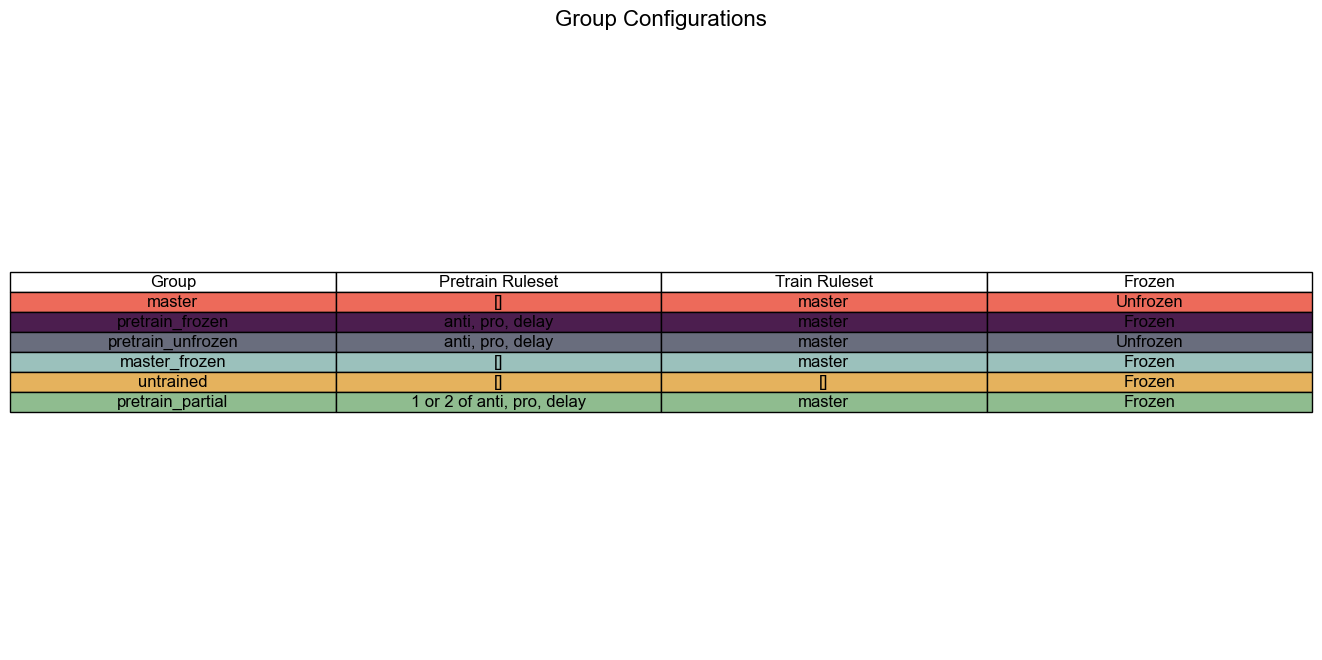

In [4]:
visualize_reduced_plots(color_mapping)

### Get dissimilarities

#### Computation dynamics

In [5]:
path = f"../data/dissimilarities/{taskset}/"
df = get_dataframe(path, taskset)



In [6]:
groups_selected = [
    "pretrain_basic_frozen",
    "pretrain_anti_frozen",
    "pretrain_delay_frozen",
    "pretrain_basic_anti_frozen",
    "pretrain_basic_delay_frozen",
]
# map all the groups in groups_selected to pretrain_partial
df_selected = df.copy()
df_selected["group2"] = df_selected["group2"].apply(lambda x: "pretrain_partial" if x in groups_selected else x)
df_selected["group1"] = df_selected["group1"].apply(lambda x: "pretrain_partial" if x in groups_selected else x)
groups_base = ["master"]
groups_selected = ["pretrain_partial", "pretrain_frozen", "pretrain_unfrozen"]
df_selected = df_selected[df_selected["group1"].isin(groups_base) & df_selected["group2"].isin(groups_selected)]

In [7]:
def discriminate_df(df_selected, groups_base, criteria):
    for measure in measures:
        fig, ax = plt.subplots(
            nrows=1, ncols=1, figsize=(20, 10), sharex=True, sharey=True
        )

        # Iterate over each group pair
        for group in groups_base:
            # ax = axes[groups_base.index(group)]

            # Prepare palette dictionary for hue levels
            hue_palette = {
                hue: color_mapping.get(hue, "gray")
                for hue in df_selected["group2"].unique()
            }

            # Plot a violin plot for the dissimilarity distribution
            sns.violinplot(
                data=df_selected[
                    (df_selected["group1"] == group)
                    & (df_selected["measure"] == measure)
                ],
                x=criteria,
                y="dissimilarity",
                hue="group2",
                ax=ax,
                inner="quart",
                palette=hue_palette,
            )
            ax.set_title(f"{group}", fontsize=8)
            ax.set_xlabel("")
            ax.set_ylabel("")

        # Adjust layout
        plt.suptitle(
            f"Distribution of Dissimilarities Across Groups for Metric : {measure}",
            fontsize=16,
        )
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

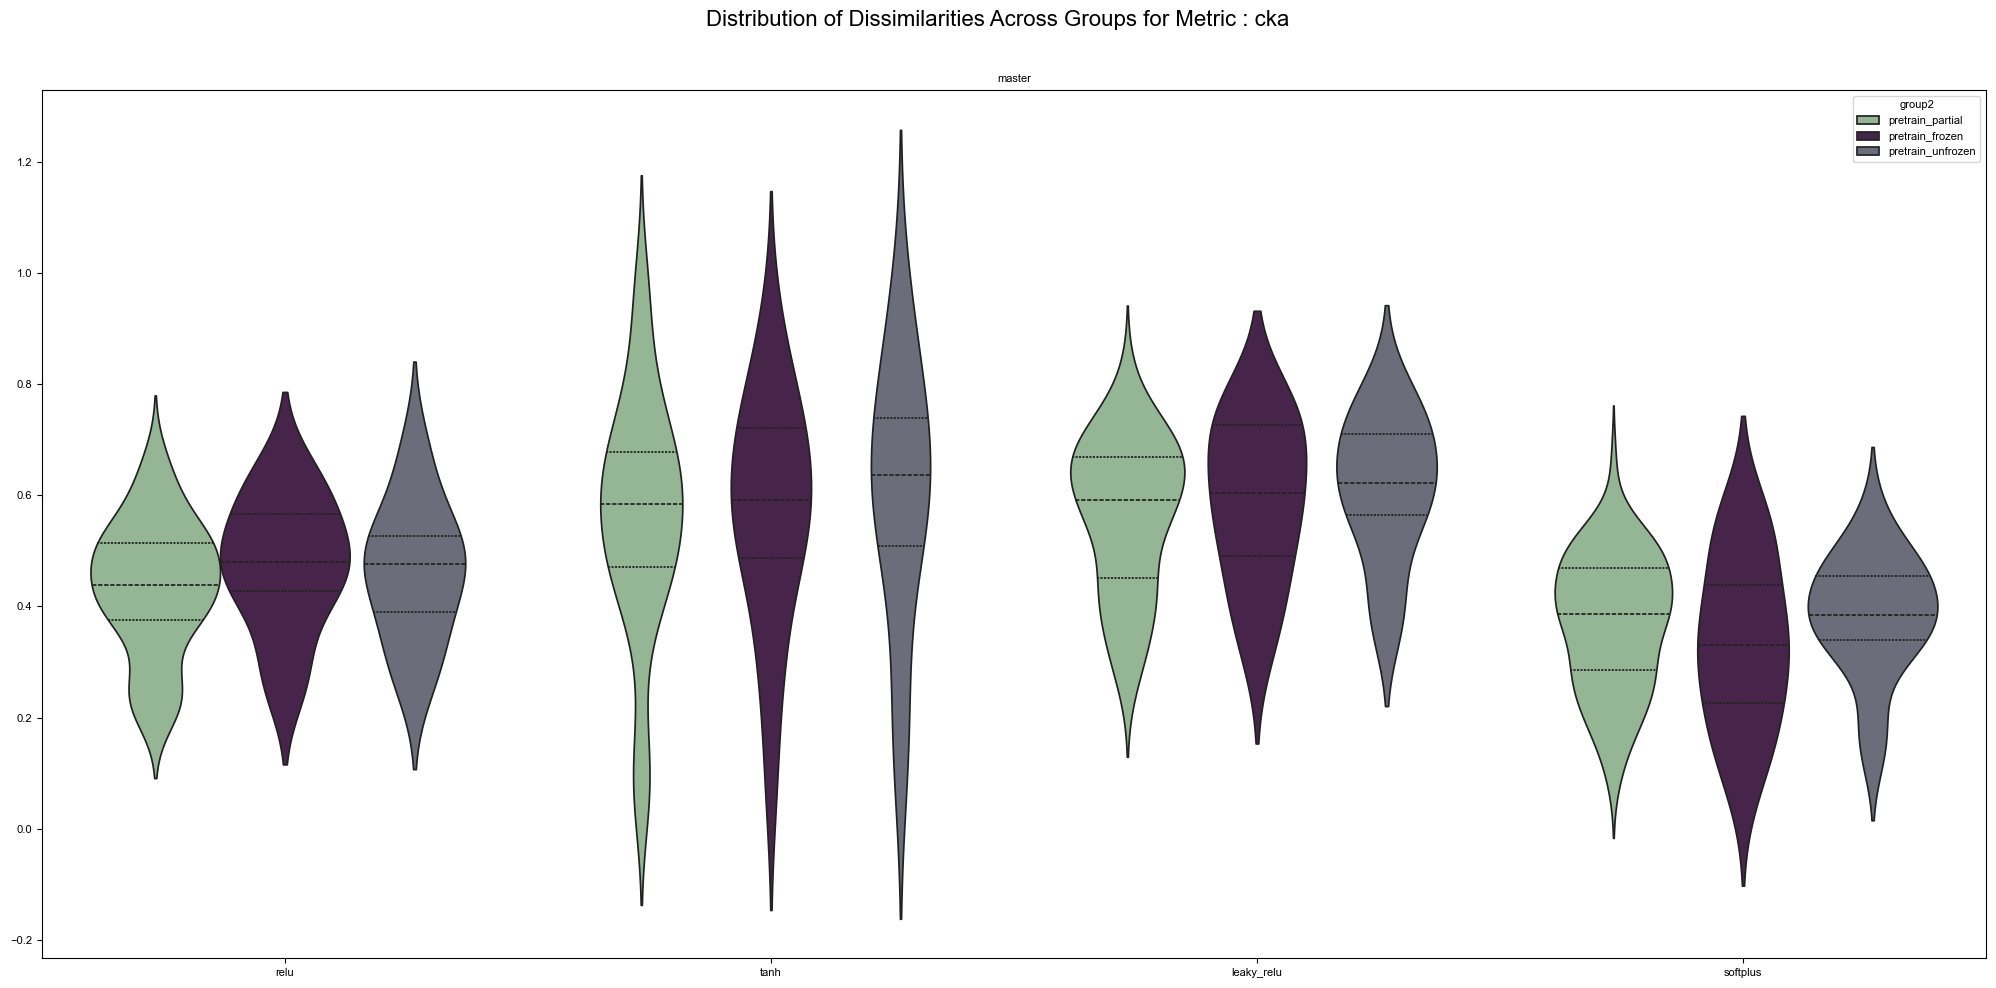

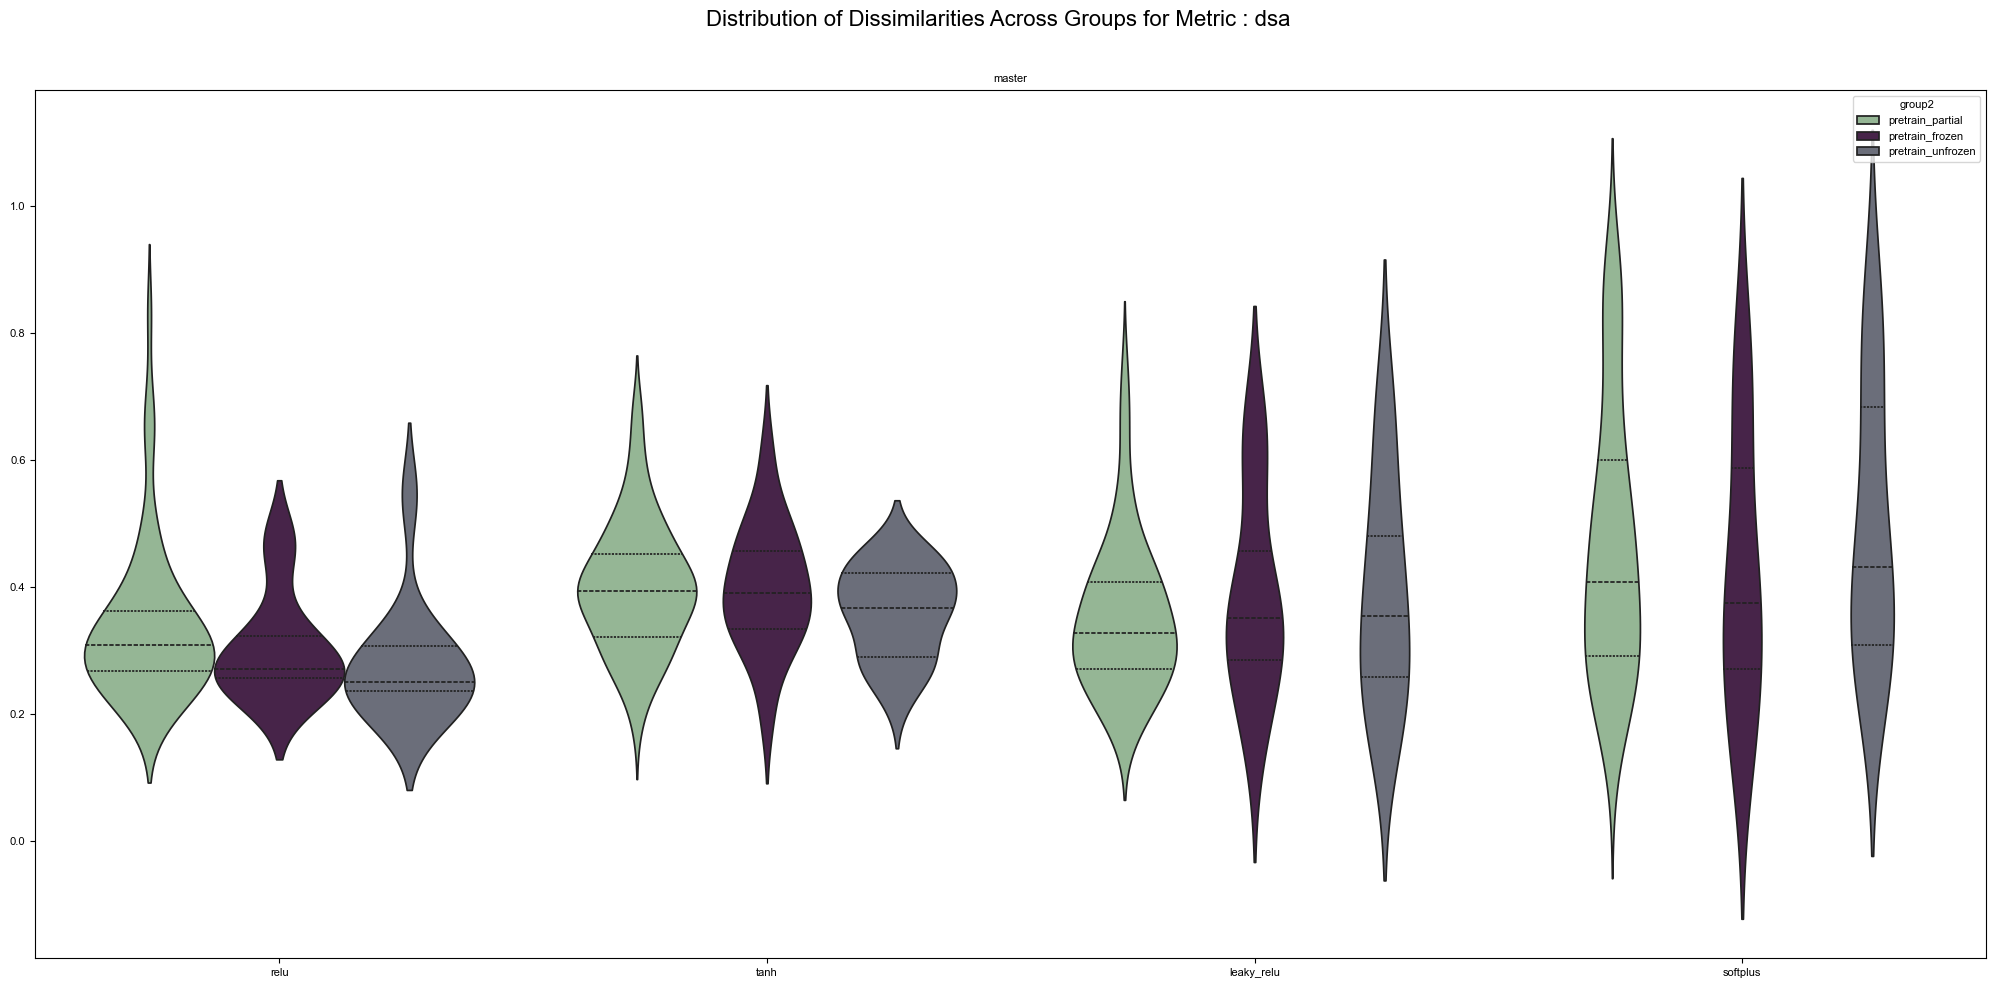

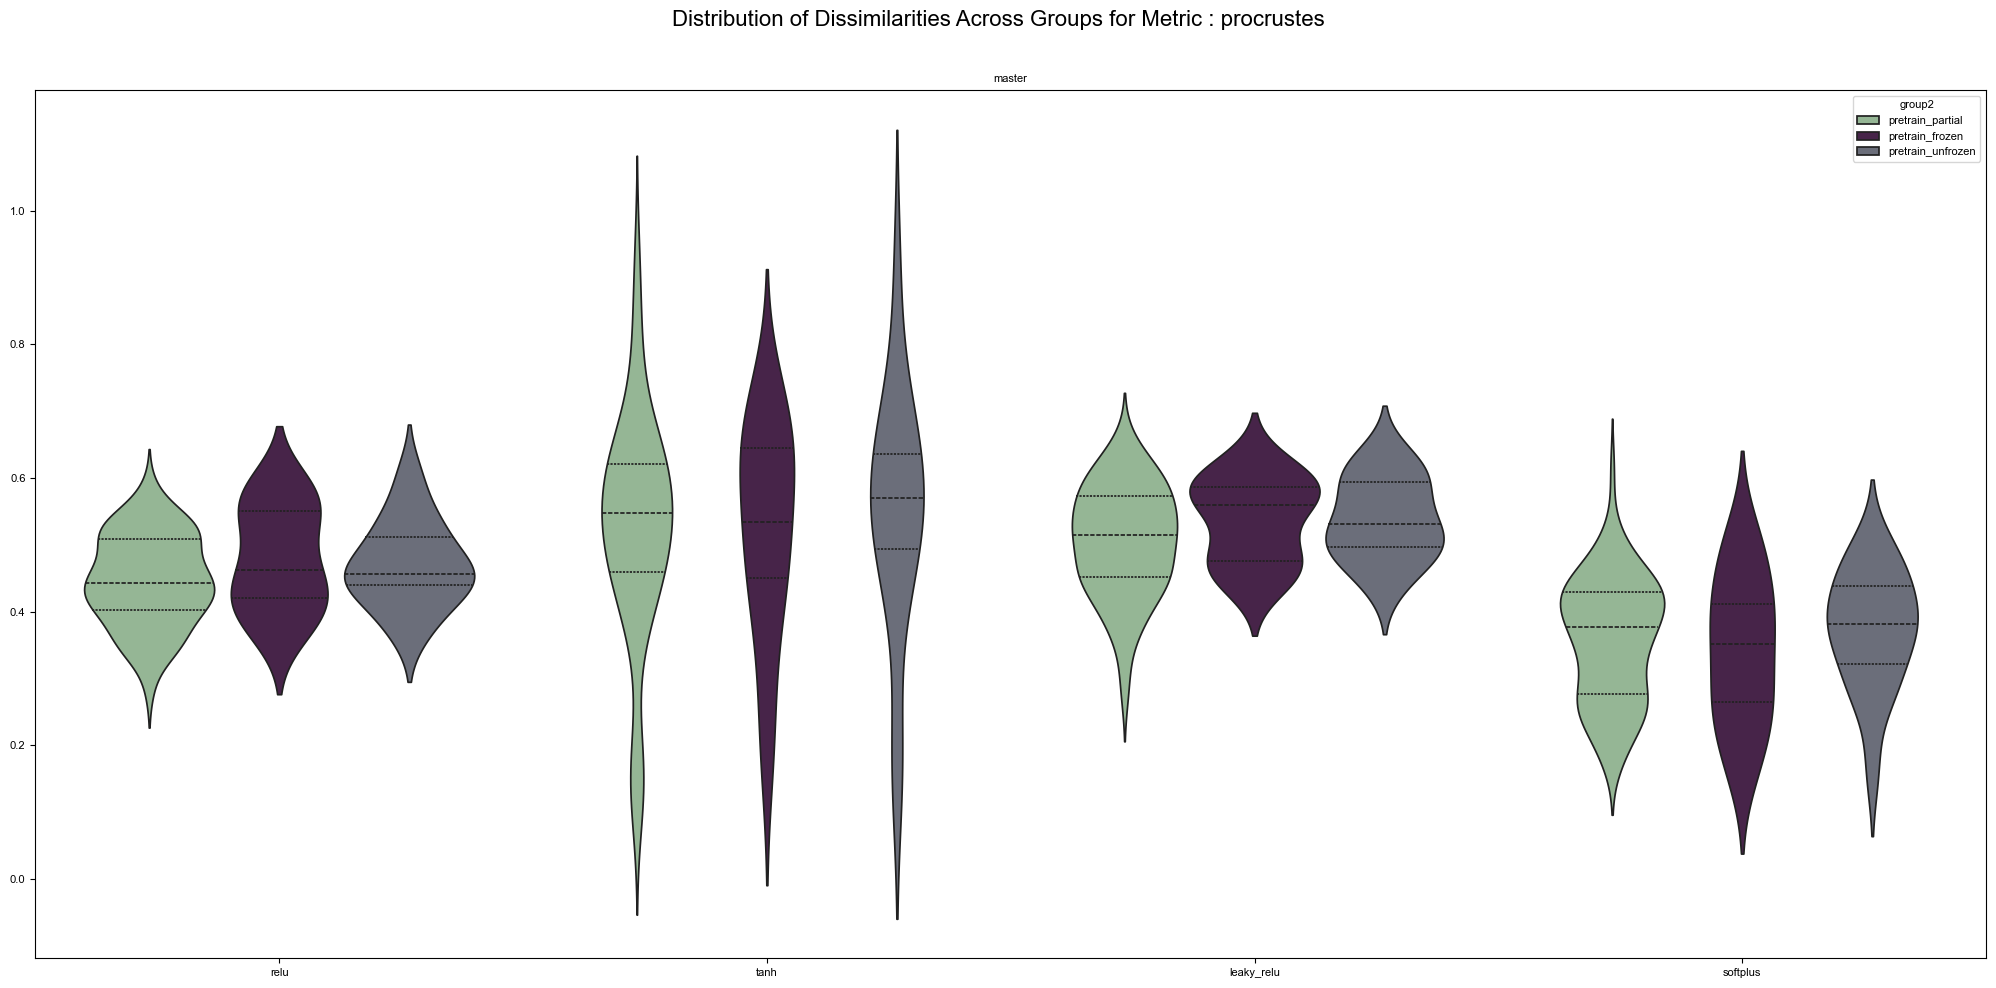

In [8]:

discriminate_df(df_selected, groups_base, criteria="activation")

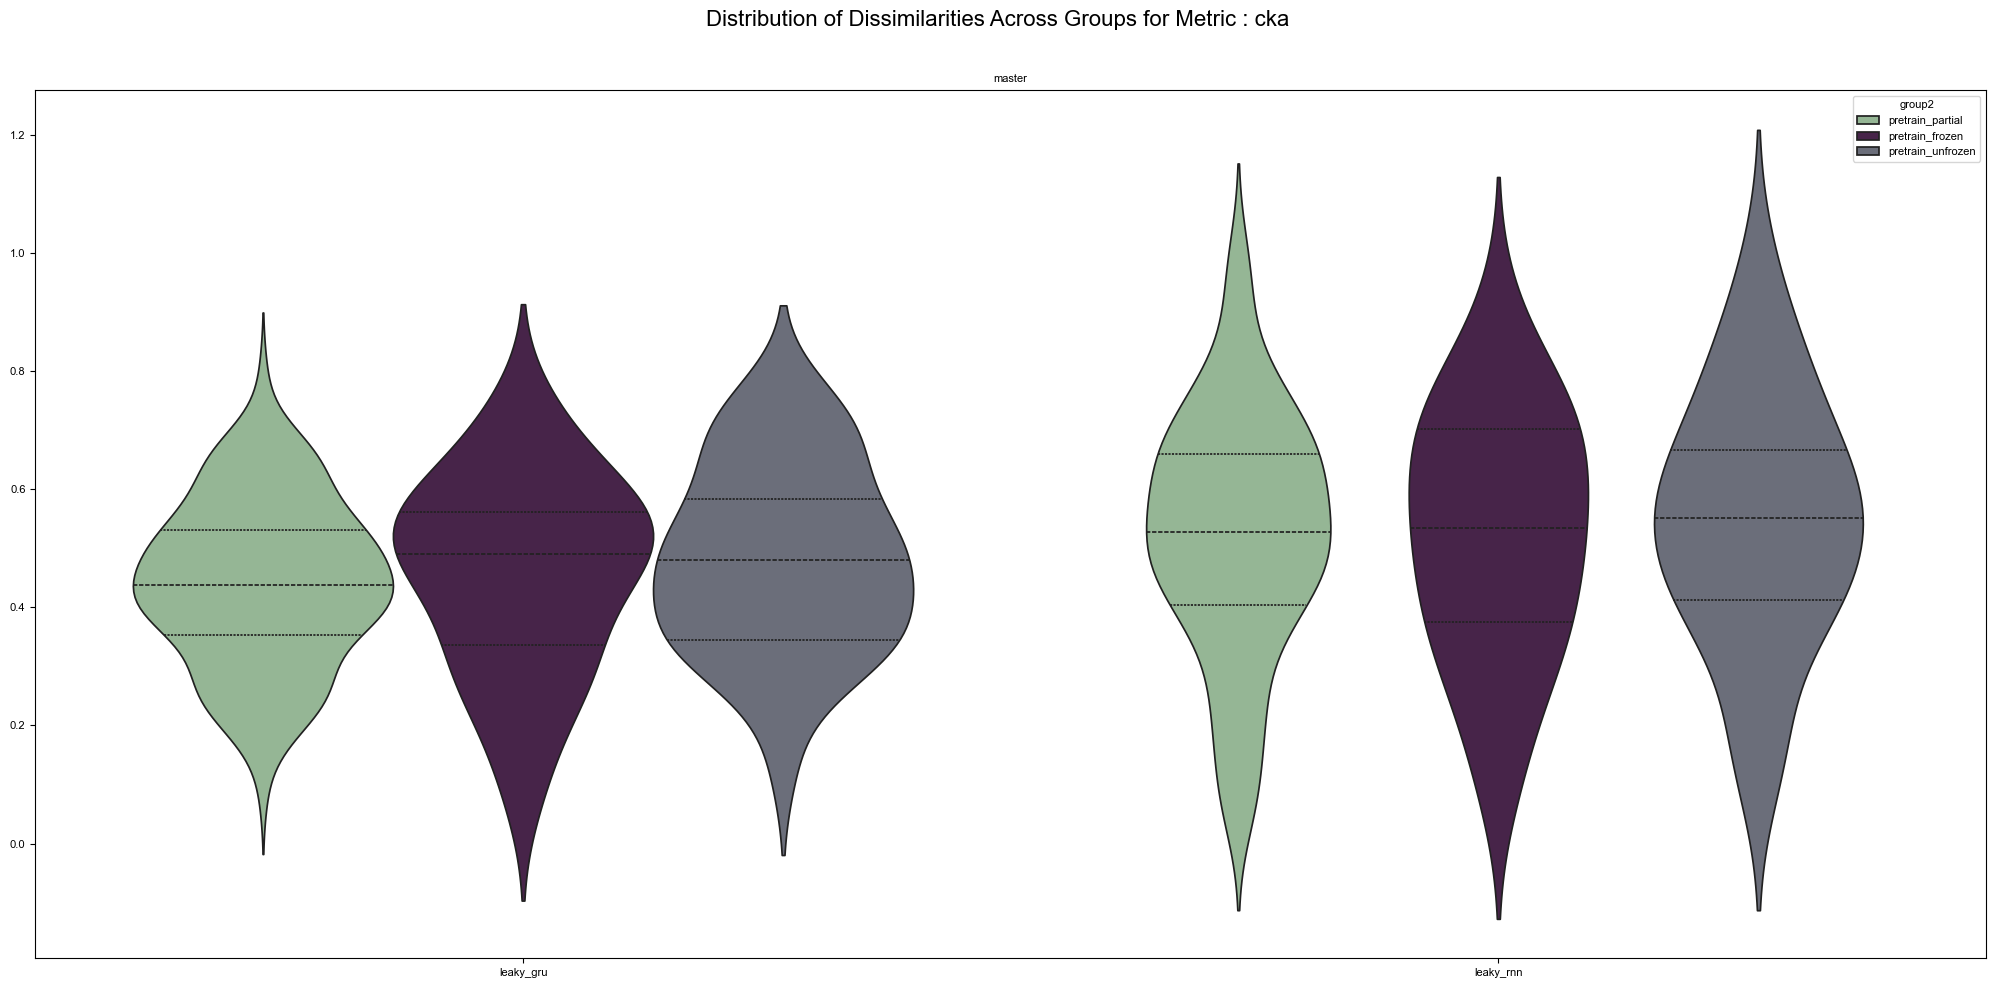

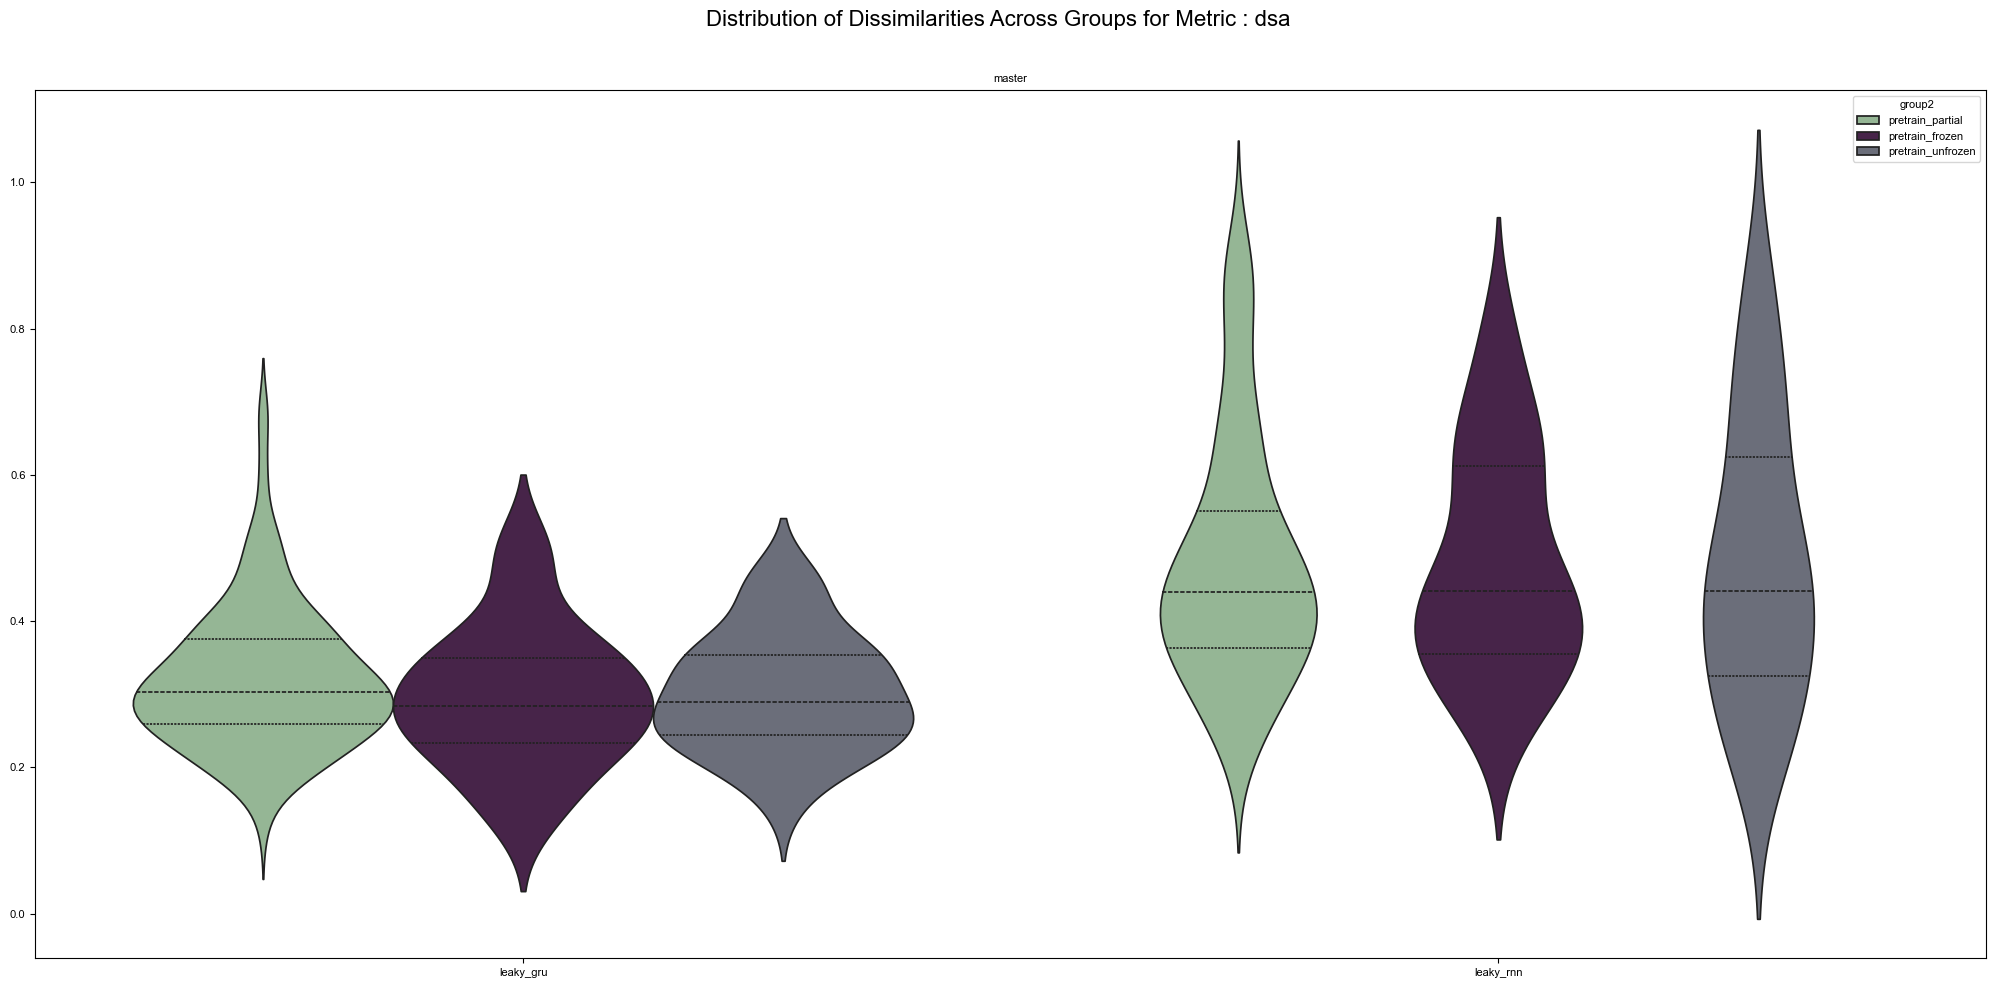

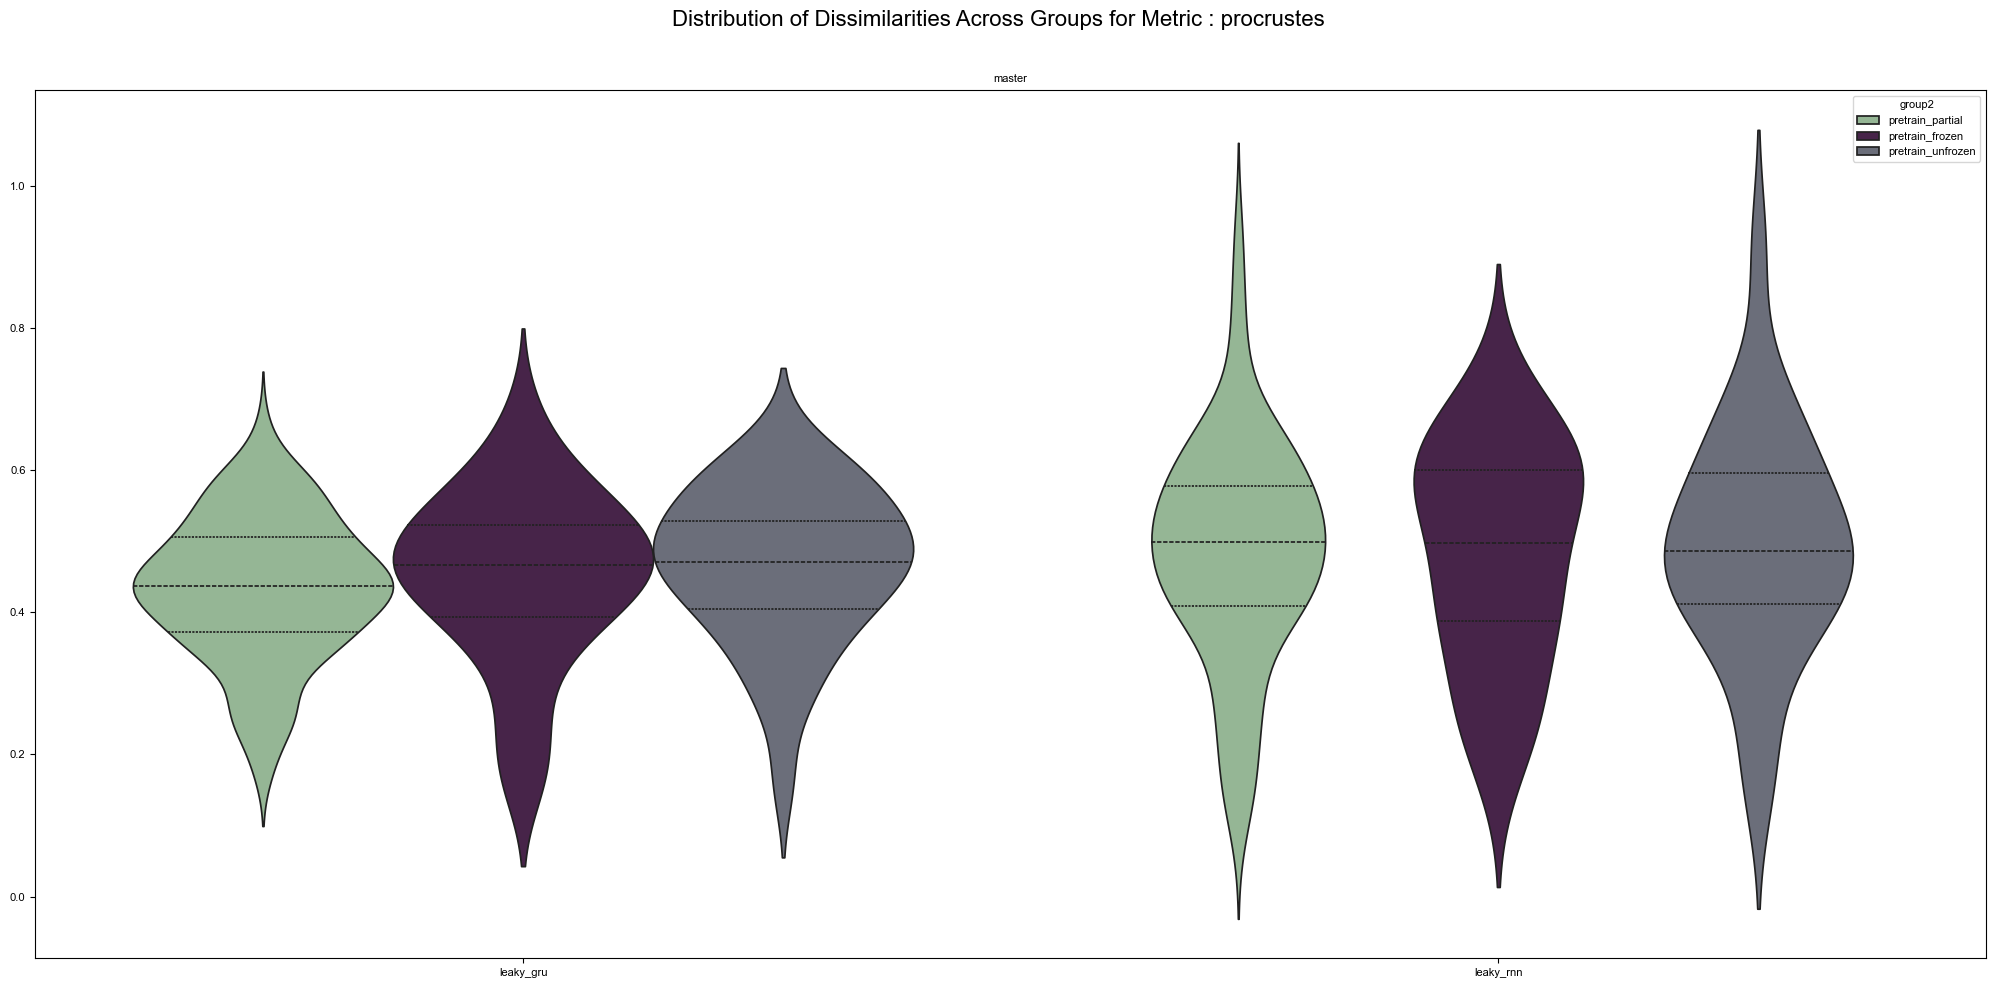

In [9]:
discriminate_df(df_selected, groups_base, criteria="model_type")

In [10]:
df_selected, models_trained_per_group = select_df(df)

In [11]:
groups_selected = [
    "pretrain_basic_frozen",
    "pretrain_anti_frozen",
    "pretrain_delay_frozen",
    "pretrain_basic_anti_frozen",
    "pretrain_basic_delay_frozen",
]
# map all the groups in groups_selected to pretrain_partial
df_grouped = df_selected.copy()
df_grouped["group2"] = df_grouped["group2"].apply(
    lambda x: "pretrain_partial" if x in groups_selected else x
)
df_grouped["group1"] = df_grouped["group1"].apply(
    lambda x: "pretrain_partial" if x in groups_selected else x
)
groups_base = ["master"]
groups_selected = ["untrained", "master_frozen", "pretrain_partial", "pretrain_frozen", "pretrain_unfrozen"]
df_grouped= df_grouped[
    df_grouped["group1"].isin(groups_base)
    & df_grouped["group2"].isin(groups_selected)
]

In [12]:
df_grouped["group2"].unique()

array(['untrained', 'master_frozen', 'pretrain_partial',
       'pretrain_frozen', 'pretrain_unfrozen'], dtype=object)

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


def discriminate_df_with_error_bars(df_selected, groups_base):
    # Create a figure with a specified size and gridspec layout
    fig = plt.figure(figsize=(20, 7))  # Adjusted figure size for horizontal layout
    gs = GridSpec(1, 3, figure=fig)  # Define a 1x3 grid layout (1 row, 3 columns)

    # Create a shared y-axis for the subplots
    shared_ax = None

    # Iterate over each measure and create a subplot for it
    for i, measure in enumerate(measures):
        # Create a subplot in the current grid location, sharing the y-axis
        ax = fig.add_subplot(gs[0, i], sharey=shared_ax)
        if shared_ax is None:
            shared_ax = ax  # Set the first axis as the shared y-axis

        # Iterate over each group pair
        for group in groups_base:
            # Filter data for the current group and measure
            data_to_plot = df_selected[
                (df_selected["group1"] == group) & (df_selected["measure"] == measure)
            ]

            # Prepare palette dictionary for hue levels
            hue_palette = [
                color_mapping.get(hue, "gray")
                for hue in data_to_plot["group2"].unique()
            ]

            # Extract unique groups for x-axis labels
            groups = data_to_plot["group2"].unique()

            # Prepare data for box plot
            data = [
                data_to_plot[data_to_plot["group2"] == g]["dissimilarity"].values
                for g in groups
            ]

            # Plot box plots for each group, making them slightly more apart
            box = ax.boxplot(
                data,
                positions=np.arange(len(groups)) * 0.5
                - 1,  # Increase spacing between boxes
                patch_artist=True,  # Fill the boxes with color
                widths=0.15,  # Adjust width of boxes to be narrower
                showfliers=False,  # Optionally hide outliers for clarity
                medianprops=dict(color="black", linewidth=2.5),  # Thicker median line
                whiskerprops=dict(linewidth=1),  # Customize whiskers
                capprops=dict(linewidth=1),  # Customize caps
                boxprops=dict(linewidth=1, alpha=0.7),  # Thinner, smoother box edges
            )

            # Set colors for each box
            for patch, color in zip(box["boxes"], hue_palette):
                patch.set_facecolor(color)

            # Calculate means and standard errors
            means = [np.mean(d) for d in data]
            errors = [
                np.std(d) / np.sqrt(len(d)) for d in data  # Standard Error of the Mean
            ]

            # Correctly align error bar x-values with boxplot positions
            x_positions = (
                np.arange(len(groups)) * 0.5 - 1 + 0.2
            )  # Positions adjusted for error bars

            # Add error bars next to each box plot, colored the same as the box
            for j, (mean, error, x_pos) in enumerate(zip(means, errors, x_positions)):
                ax.errorbar(
                    x=x_pos,  # Use the corrected x-position
                    y=mean,
                    yerr=error,
                    fmt="o",  # Circle marker for means
                    color=box["boxes"][
                        j
                    ].get_facecolor(),  # Match error bar color with respective boxplot
                    ecolor=box["boxes"][
                        j
                    ].get_facecolor(),  # Match error bar color with respective boxplot
                    elinewidth=1.5,  # Error bar line width
                    capsize=4,  # Add caps to error bars
                    capthick=1.5,  # Cap thickness
                    linestyle="none",  # No line connecting points
                )

            # Set x-axis labels and ticks
            ax.set_xlabel("")  # Remove x-axis label
            ax.set_xticks(np.arange(len(groups)) * 0.5 - 1)
            ax.set_xticklabels(groups, rotation=0)  # Set group names horizontally

            # Color group names according to the corresponding box color
            for tick_label, color in zip(ax.get_xticklabels(), hue_palette):
                tick_label.set_color(color)

        # Customize plot appearance
        ax.spines["right"].set_visible(False)  # Hide right spine
        ax.spines["top"].set_visible(False)  # Hide top spine
        ax.spines["bottom"].set_visible(False)  # Hide bottom spine

        # Set the title for each subplot, using the color from color_mapping_measure
        ax.set_title(f"{measure.upper()}", color=color_mapping_metrics.get(measure, "black"))

    # Hide the y-axis labels and ticks for all but the first subplot
    for ax in fig.axes[1:]:
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(left=False)  # Hide the y-axis scale

    # Set y-axis label for the first subplot only
    fig.axes[0].set_ylabel("Dissimilarity")

    # Adjust layout and display the plot
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to avoid overlapping
    plt.suptitle(
        "Distribution of Dissimilarities Across Groups for Different Measures",
        fontsize=16,
    )
    plt.show()

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Dictionary to map internal group names to display names
group_mapping_names = {
    "master": "Master",
    "untrained": "Untrained",
    "master_frozen": "Master & Frozen",
    "pretrain_partial": "Partial Pretraining",
    "pretrain_basic_frozen": "Pretrain Basic Frozen",
    "pretrain_frozen": "Full Pretraining",
    "pretrain_unfrozen": "Full Pretraining & Unfrozen",
}


def discriminate_df_with_error_bars(df_selected, groups_base):
    # Create a figure with a specified size and gridspec layout
    fig = plt.figure(figsize=(20, 7))  # Adjusted figure size for horizontal layout
    gs = GridSpec(1, 3, figure=fig)  # Define a 1x3 grid layout (1 row, 3 columns)

    # Create a shared y-axis for the subplots
    shared_ax = None

    # Iterate over each measure and create a subplot for it
    for i, measure in enumerate(measures):
        # Create a subplot in the current grid location, sharing the y-axis
        ax = fig.add_subplot(gs[0, i], sharey=shared_ax)
        if shared_ax is None:
            shared_ax = ax  # Set the first axis as the shared y-axis

        # Iterate over each group pair
        for group in groups_base:
            # Filter data for the current group and measure
            data_to_plot = df_selected[
                (df_selected["group1"] == group) & (df_selected["measure"] == measure)
            ]

            # Prepare palette dictionary for hue levels
            hue_palette = [
                color_mapping.get(hue, "gray")
                for hue in data_to_plot["group2"].unique()
            ]

            # Extract unique groups for x-axis labels
            groups = data_to_plot["group2"].unique()

            # Prepare data for box plot
            data = [
                data_to_plot[data_to_plot["group2"] == g]["dissimilarity"].values
                for g in groups
            ]

            # Plot box plots for each group, making them slightly more apart
            box = ax.boxplot(
                data,
                positions=np.arange(len(groups)) * 0.6
                - 1,  # Increase spacing between boxes
                patch_artist=True,  # Fill the boxes with color
                widths=0.15,  # Adjust width of boxes to be narrower
                showfliers=False,  # Optionally hide outliers for clarity
                medianprops=dict(color="black", linewidth=2.5),  # Thicker median line
                whiskerprops=dict(linewidth=1),  # Customize whiskers
                capprops=dict(linewidth=1),  # Customize caps
                boxprops=dict(linewidth=1, alpha=0.7),  # Thinner, smoother box edges
            )

            # Set colors for each box
            for patch, color in zip(box["boxes"], hue_palette):
                patch.set_facecolor(color)

            # Calculate means and standard errors
            means = [np.mean(d) for d in data]
            errors = [
                np.std(d) / np.sqrt(len(d)) for d in data  # Standard Error of the Mean
            ]

            # Correctly align error bar x-values with boxplot positions
            x_positions = (
                np.arange(len(groups)) * 0.6 - 1 + 0.2
            )  # Positions adjusted for error bars

            # Add error bars next to each box plot, colored the same as the box
            for j, (mean, error, x_pos) in enumerate(zip(means, errors, x_positions)):
                ax.errorbar(
                    x=x_pos,  # Use the corrected x-position
                    y=mean,
                    yerr=error,
                    fmt="o",  # Circle marker for means
                    color=box["boxes"][
                        j
                    ].get_facecolor(),  # Match error bar color with respective boxplot
                    ecolor=box["boxes"][
                        j
                    ].get_facecolor(),  # Match error bar color with respective boxplot
                    elinewidth=1.5,  # Error bar line width
                    capsize=4,  # Add caps to error bars
                    capthick=1.5,  # Cap thickness
                    linestyle="none",  # No line connecting points
                )

            # Set x-axis labels and ticks using the mapped display names
            ax.set_xlabel("")  # Remove x-axis label
            ax.set_xticks(np.arange(len(groups)) * 0.6 - 1)
            ax.set_xticklabels(
                [group_mapping_names.get(g, g) for g in groups], rotation=0
            )  # Use display names from the mapping

            # Color group names according to the corresponding box color
            for tick_label, color in zip(ax.get_xticklabels(), hue_palette):
                tick_label.set_color(color)

        # Customize plot appearance
        ax.spines["right"].set_visible(False)  # Hide right spine
        ax.spines["top"].set_visible(False)  # Hide top spine
        ax.spines["bottom"].set_visible(False)  # Hide bottom spine

        # Set the title for each subplot, using the color from color_mapping_measure
        ax.set_title(
            f"{measure.upper()}", color=color_mapping_metrics.get(measure, "black")
        )

    # Hide the y-axis labels and ticks for all but the first subplot
    for ax in fig.axes[1:]:
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(left=False)  # Hide the y-axis scale

    # Set y-axis label for the first subplot only
    fig.axes[0].set_ylabel("Dissimilarity")

    # Adjust layout and display the plot
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to avoid overlapping
    plt.suptitle(
        "Distribution of Dissimilarities Across Groups for Different Measures",
        fontsize=16,
    )
    plt.show()

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import textwrap  # Import textwrap for wrapping text

# Dictionary to map internal group names to display names
group_mapping_names = {
    "master": "Master",
    "untrained": "Untrained",
    "master_frozen": "Master & Frozen",
    "pretrain_partial": "Partial Pretraining",
    "pretrain_basic_frozen": "Pretrain Basic Frozen",
    "pretrain_frozen": "Full Pretraining",
    "pretrain_unfrozen": "Full Pretraining & Unfrozen",
}


def wrap_group_name(group_name, max_width=15):
    """
    Wrap the group name to fit within a certain width, breaking into two lines if necessary.
    """
    return "\n".join(textwrap.wrap(group_name, width=max_width))


def discriminate_df_with_error_bars(df_selected, groups_base):
    # Create a figure with a specified size and gridspec layout
    fig = plt.figure(figsize=(20, 7))  # Adjusted figure size for horizontal layout
    gs = GridSpec(1, 3, figure=fig)  # Define a 1x3 grid layout (1 row, 3 columns)

    # Create a shared y-axis for the subplots
    shared_ax = None

    # Iterate over each measure and create a subplot for it
    for i, measure in enumerate(measures):
        # Create a subplot in the current grid location, sharing the y-axis
        ax = fig.add_subplot(gs[0, i], sharey=shared_ax)
        if shared_ax is None:
            shared_ax = ax  # Set the first axis as the shared y-axis

        # Iterate over each group pair
        for group in groups_base:
            # Filter data for the current group and measure
            data_to_plot = df_selected[
                (df_selected["group1"] == group) & (df_selected["measure"] == measure)
            ]

            # Prepare palette dictionary for hue levels
            hue_palette = [
                color_mapping.get(hue, "gray")
                for hue in data_to_plot["group2"].unique()
            ]

            # Extract unique groups for x-axis labels
            groups = data_to_plot["group2"].unique()

            # Prepare data for box plot
            data = [
                data_to_plot[data_to_plot["group2"] == g]["dissimilarity"].values
                for g in groups
            ]

            # Plot box plots for each group, making them slightly more apart
            box = ax.boxplot(
                data,
                positions=np.arange(len(groups)) * 0.5
                - 1,  # Increase spacing between boxes
                patch_artist=True,  # Fill the boxes with color
                widths=0.15,  # Adjust width of boxes to be narrower
                showfliers=False,  # Optionally hide outliers for clarity
                medianprops=dict(color="black", linewidth=2.5),  # Thicker median line
                whiskerprops=dict(linewidth=1),  # Customize whiskers
                capprops=dict(linewidth=1),  # Customize caps
                boxprops=dict(linewidth=1, alpha=0.7),  # Thinner, smoother box edges
            )

            # Set colors for each box
            for patch, color in zip(box["boxes"], hue_palette):
                patch.set_facecolor(color)

            # Calculate means and standard errors
            means = [np.mean(d) for d in data]
            errors = [
                np.std(d) / np.sqrt(len(d)) for d in data  # Standard Error of the Mean
            ]

            # Correctly align error bar x-values with boxplot positions
            x_positions = (
                np.arange(len(groups)) * 0.5 - 1 + 0.2
            )  # Positions adjusted for error bars

            # Add error bars next to each box plot, colored the same as the box
            for j, (mean, error, x_pos) in enumerate(zip(means, errors, x_positions)):
                ax.errorbar(
                    x=x_pos,  # Use the corrected x-position
                    y=mean,
                    yerr=error,
                    fmt="o",  # Circle marker for means
                    color=box["boxes"][
                        j
                    ].get_facecolor(),  # Match error bar color with respective boxplot
                    ecolor=box["boxes"][
                        j
                    ].get_facecolor(),  # Match error bar color with respective boxplot
                    elinewidth=1.5,  # Error bar line width
                    capsize=4,  # Add caps to error bars
                    capthick=1.5,  # Cap thickness
                    linestyle="none",  # No line connecting points
                )

            # Set x-axis labels and ticks using the mapped display names
            ax.set_xlabel("")  # Remove x-axis label
            ax.set_xticks(np.arange(len(groups)) * 0.5 - 1)
            # Wrap the group names to fit within the plot
            ax.set_xticklabels(
                [wrap_group_name(group_mapping_names.get(g, g)) for g in groups],
                rotation=0,
            )

            # Color group names according to the corresponding box color
            for tick_label, color in zip(ax.get_xticklabels(), hue_palette):
                tick_label.set_color(color)

        # Customize plot appearance
        ax.spines["right"].set_visible(False)  # Hide right spine
        ax.spines["top"].set_visible(False)  # Hide top spine
        ax.spines["bottom"].set_visible(False)  # Hide bottom spine

        # Set the title for each subplot, using the color from color_mapping_measure
        ax.set_title(
            f"{measure.upper()}", color=color_mapping_metrics.get(measure, "black")
        )

    # Hide the y-axis labels and ticks for all but the first subplot
    for ax in fig.axes[1:]:
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(left=False)  # Hide the y-axis scale

    # Set y-axis label for the first subplot only
    fig.axes[0].set_ylabel("Dissimilarity")

    # Adjust layout and display the plot
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to avoid overlapping
    plt.suptitle(
        "Distribution of Dissimilarities Across Groups for Different Measures",
        fontsize=16,
    )
    plt.show()

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import textwrap  # Import textwrap for wrapping text

# Dictionary to map internal group names to display names
group_mapping_names = {
    "master": "Master",
    "untrained": "Untrained",
    "master_frozen": "Master & Frozen",
    "pretrain_partial": "Partial Pretraining",
    "pretrain_basic_frozen": "Pretrain Basic Frozen",
    "pretrain_frozen": "Full Pretraining",
    "pretrain_unfrozen": "Full Pretraining & Unfrozen",
}


def wrap_group_name(group_name, max_width=15):
    """
    Wrap the group name to fit within a certain width, breaking into two lines if necessary.
    """
    return "\n".join(textwrap.wrap(group_name, width=max_width))


def discriminate_df_with_error_bars(df_selected, groups_base):
    # Create a figure with a specified size and gridspec layout
    fig = plt.figure(figsize=(30, 8))  # Reduced figure height
    gs = GridSpec(
        1, 3, figure=fig, wspace=0.1, hspace=0.5
    )  # Reduce horizontal and vertical spacing

    # Iterate over each measure and create a subplot for it
    for i, measure in enumerate(measures):
        ax = fig.add_subplot(gs[0, i])

        # Iterate over each group pair
        for group in groups_base:
            # Filter data for the current group and measure
            data_to_plot = df_selected[
                (df_selected["group1"] == group) & (df_selected["measure"] == measure)
            ]

            # Prepare palette dictionary for hue levels
            hue_palette = [
                color_mapping.get(hue, "gray")
                for hue in data_to_plot["group2"].unique()
            ]

            # Extract unique groups for x-axis labels
            groups = data_to_plot["group2"].unique()

            # Prepare data for box plot
            data = [
                data_to_plot[data_to_plot["group2"] == g]["dissimilarity"].values
                for g in groups
            ]

            # Plot box plots for each group, making them slightly more apart
            box = ax.boxplot(
                data,
                positions=np.arange(len(groups)) * 0.6
                - 1.25,  # Increase spacing between boxes
                patch_artist=True,  # Fill the boxes with color
                widths=0.15,  # Adjust width of boxes to be narrower
                showfliers=False,  # Optionally hide outliers for clarity
                medianprops=dict(color="black", linewidth=2.5),  # Thicker median line
                whiskerprops=dict(linewidth=1),  # Customize whiskers
                capprops=dict(linewidth=1),  # Customize caps
                boxprops=dict(linewidth=1, alpha=0.7),  # Thinner, smoother box edges
            )

            # Set colors for each box
            for patch, color in zip(box["boxes"], hue_palette):
                patch.set_facecolor(color)

            # Calculate means and standard errors
            means = [np.mean(d) for d in data]
            errors = [
                np.std(d) / np.sqrt(len(d)) for d in data  # Standard Error of the Mean
            ]

            # Correctly align error bar x-values with boxplot positions
            x_positions = (
                np.arange(len(groups)) * 0.6 - 1.25 + 0.2
            )  # Positions adjusted for error bars

            # Add error bars next to each box plot, colored the same as the box
            for j, (mean, error, x_pos) in enumerate(zip(means, errors, x_positions)):
                ax.errorbar(
                    x=x_pos,  # Use the corrected x-position
                    y=mean,
                    yerr=error,
                    fmt="o",  # Circle marker for means
                    color=box["boxes"][
                        j
                    ].get_facecolor(),  # Match error bar color with respective boxplot
                    ecolor=box["boxes"][
                        j
                    ].get_facecolor(),  # Match error bar color with respective boxplot
                    elinewidth=1.5,  # Error bar line width
                    capsize=4,  # Add caps to error bars
                    capthick=1.5,  # Cap thickness
                    linestyle="none",  # No line connecting points
                )

            # Set x-axis labels and ticks using the mapped display names
            ax.set_xlabel("")  # Remove x-axis label
            ax.set_xticks(np.arange(len(groups)) * 0.6 - 1.25)
            # Wrap the group names to fit within the plot
            ax.set_xticklabels(
                [wrap_group_name(group_mapping_names.get(g, g)) for g in groups],
                rotation=0,
            )

            # Color group names according to the corresponding box color
            for tick_label, color in zip(ax.get_xticklabels(), hue_palette):
                tick_label.set_color(color)

        # Customize plot appearance
        ax.spines["right"].set_visible(False)  # Hide right spine
        ax.spines["top"].set_visible(False)  # Hide top spine
        ax.spines["bottom"].set_visible(False)  # Hide bottom spine

        # Set the title for each subplot, using the color from color_mapping_measure
        ax.set_title(
            f"{measure.upper()}", color=color_mapping_metrics.get(measure, "black")
        )

        # Reduce white space between y-axis and first boxplot
        ax.set_xlim([-1.5, len(groups) * 0.5 - 0.75])  # Adjust the x-limits

    # Show y-axis labels for all subplots
    for ax in fig.axes:
        plt.setp(ax.get_yticklabels(), visible=True)
        ax.tick_params(left=True)  # Ensure y-axis ticks are visible

    # Set y-axis label for the first subplot only
    fig.axes[0].set_ylabel("Dissimilarity")

    # Adjust layout and display the plot
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to avoid overlapping
    # plt.suptitle(
    #     "Distribution of Dissimilarities Across Groups for Different Measures",
    #     fontsize=16,
    # )
    # plt.show()
    plt.show()

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap  # Import textwrap for wrapping text

# Dictionary to map internal group names to display names
group_mapping_names = {
    "master": "Master",
    "untrained": "Untrained",
    "master_frozen": "Master & Frozen",
    "pretrain_partial": "Partial Pretraining",
    "pretrain_basic_frozen": "Pretrain Basic\nFrozen",
    "pretrain_frozen": "Full Pretraining",
    "pretrain_unfrozen": "Full Pretraining\n& Unfrozen",
}


def wrap_group_name(group_name, max_width=15):
    """
    Wrap the group name to fit within a certain width, breaking into two lines if necessary.
    """
    return "\n".join(textwrap.wrap(group_name, width=max_width))


def discriminate_df_with_error_bars(df_selected, groups_base):
    # Iterate over each measure and create a distinct plot for each
    for measure in measures:
        # Create a new figure for each measure
        fig, ax = plt.subplots(figsize=(6, 4), dpi=500)  # Adjust size as needed

        # Iterate over each group pair
        for group in groups_base:
            # Filter data for the current group and measure
            data_to_plot = df_selected[
                (df_selected["group1"] == group) & (df_selected["measure"] == measure)
            ]

            # Prepare palette dictionary for hue levels
            hue_palette = [
                color_mapping.get(hue, "gray")
                for hue in data_to_plot["group2"].unique()
            ]

            # Extract unique groups for x-axis labels
            groups = data_to_plot["group2"].unique()

            # Prepare data for box plot
            data = [
                data_to_plot[data_to_plot["group2"] == g]["dissimilarity"].values
                for g in groups
            ]

            # Plot box plots for each group, making them slightly more apart
            box = ax.boxplot(
                data,
                positions=np.arange(len(groups)) * 0.5
                - 1.25,  # Increase spacing between boxes
                patch_artist=True,  # Fill the boxes with color
                widths=0.15,  # Adjust width of boxes to be narrower
                showfliers=False,  # Optionally hide outliers for clarity
                medianprops=dict(color="black", linewidth=2.5),  # Thicker median line
                whiskerprops=dict(linewidth=1),  # Customize whiskers
                capprops=dict(linewidth=1),  # Customize caps
                boxprops=dict(linewidth=1, alpha=0.7),  # Thinner, smoother box edges
            )

            # Set colors for each box
            for patch, color in zip(box["boxes"], hue_palette):
                patch.set_facecolor(color)

            # Calculate means and standard errors
            means = [np.mean(d) for d in data]
            errors = [
                np.std(d) / np.sqrt(len(d)) for d in data  # Standard Error of the Mean
            ]

            # Correctly align error bar x-values with boxplot positions
            x_positions = (
                np.arange(len(groups)) * 0.5 - 1.25 + 0.2
            )  # Positions adjusted for error bars

            # Add error bars next to each box plot, colored the same as the box
            for j, (mean, error, x_pos) in enumerate(zip(means, errors, x_positions)):
                ax.errorbar(
                    x=x_pos,  # Use the corrected x-position
                    y=mean,
                    yerr=error,
                    fmt="o",  # Circle marker for means
                    color=box["boxes"][
                        j
                    ].get_facecolor(),  # Match error bar color with respective boxplot
                    ecolor=box["boxes"][
                        j
                    ].get_facecolor(),  # Match error bar color with respective boxplot
                    elinewidth=1.5,  # Error bar line width
                    capsize=4,  # Add caps to error bars
                    capthick=1.5,  # Cap thickness
                    linestyle="none",  # No line connecting points
                )

            # Set x-axis labels and ticks using the mapped display names
            ax.set_xlabel("")  # Remove x-axis label
            ax.set_xticks(np.arange(len(groups)) * 0.5 - 1.25)
            # Wrap the group names to fit within the plot
            ax.set_xticklabels(
                [wrap_group_name(group_mapping_names.get(g, g)) for g in groups],
                rotation=0,
            )

            # Color group names according to the corresponding box color
            for tick_label, color in zip(ax.get_xticklabels(), hue_palette):
                tick_label.set_color(color)

        # Customize plot appearance
        ax.spines["right"].set_visible(False)  # Hide right spine
        ax.spines["top"].set_visible(False)  # Hide top spine
        ax.spines["bottom"].set_visible(False)  # Hide bottom spine

        # Remove the title for each measure
        # ax.set_title(f"{measure.upper()}", color=color_mapping_metrics.get(measure, "black"))

        # Reduce white space between y-axis and first boxplot
        ax.set_xlim([-1.5, len(groups) * 0.5 - 0.75])  # Adjust the x-limits

        # Show y-axis labels for all subplots
        plt.setp(ax.get_yticklabels(), visible=True)
        ax.tick_params(left=True)  # Ensure y-axis ticks are visible

        # Set y-axis label for the first subplot only
        ax.set_ylabel("Dissimilarity")

        # Adjust layout and display the plot
        plt.tight_layout()  # Adjust layout to avoid overlapping
        plt.show()  # Show each figure separately

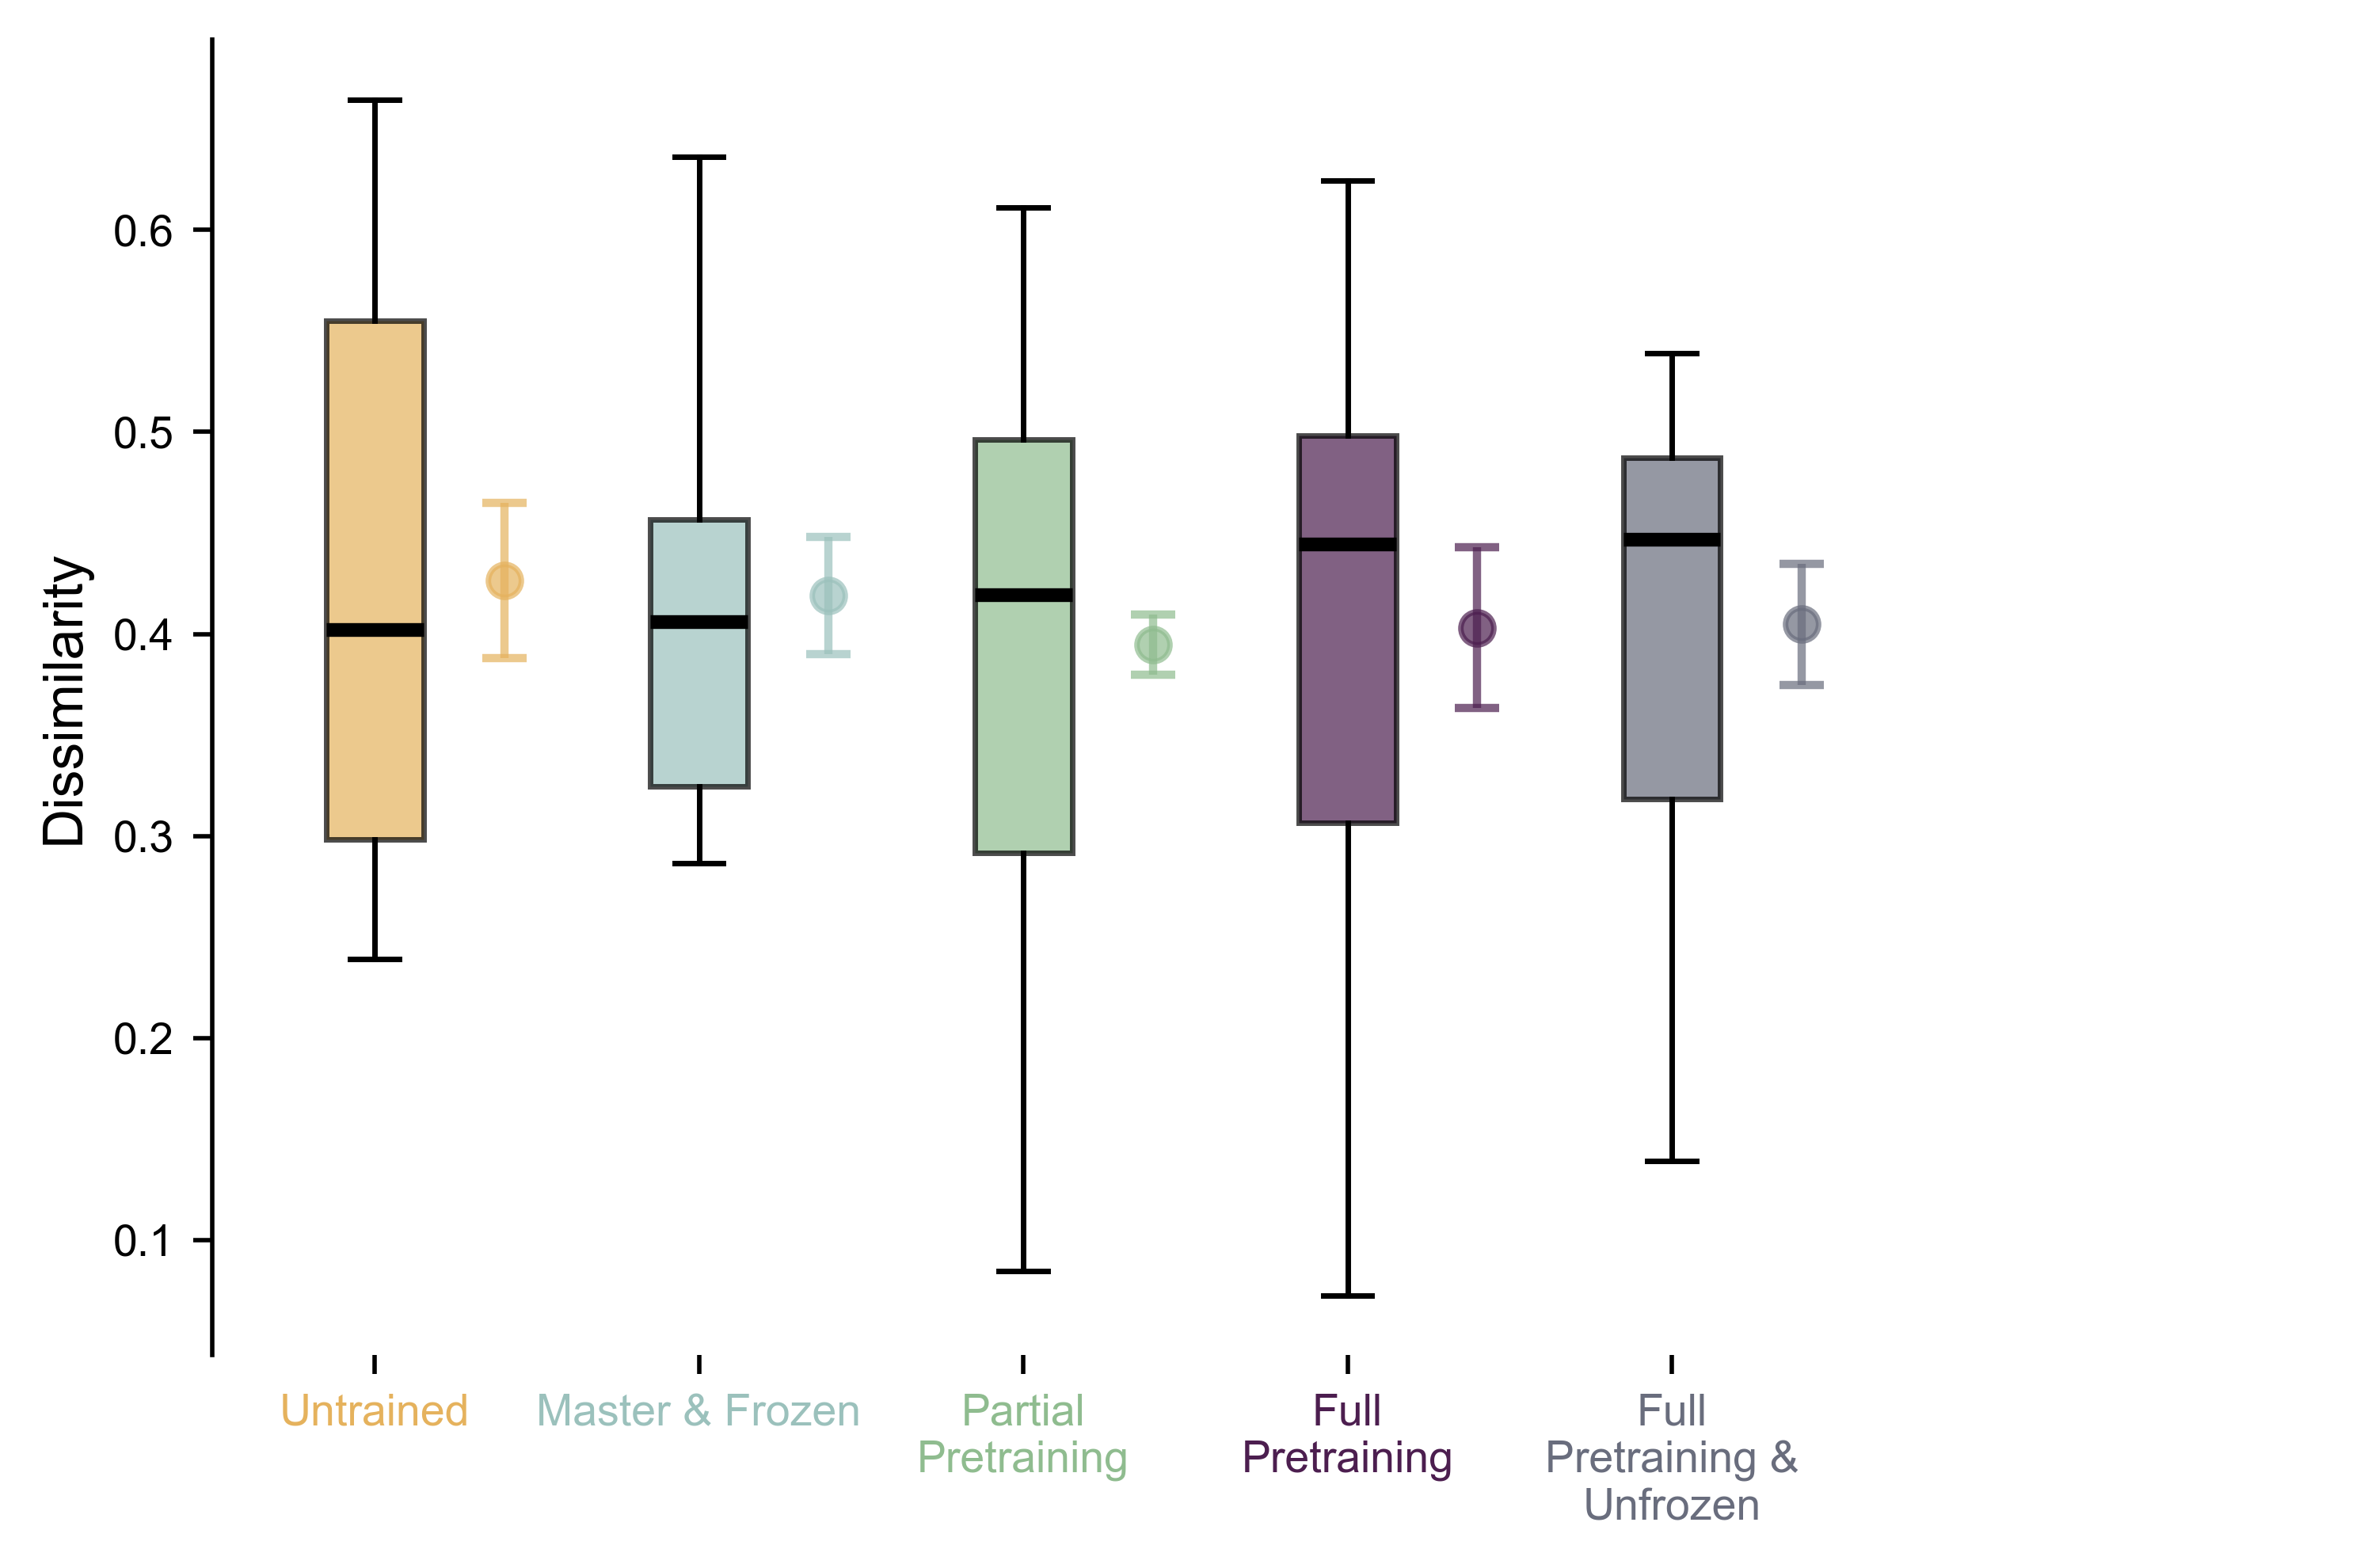

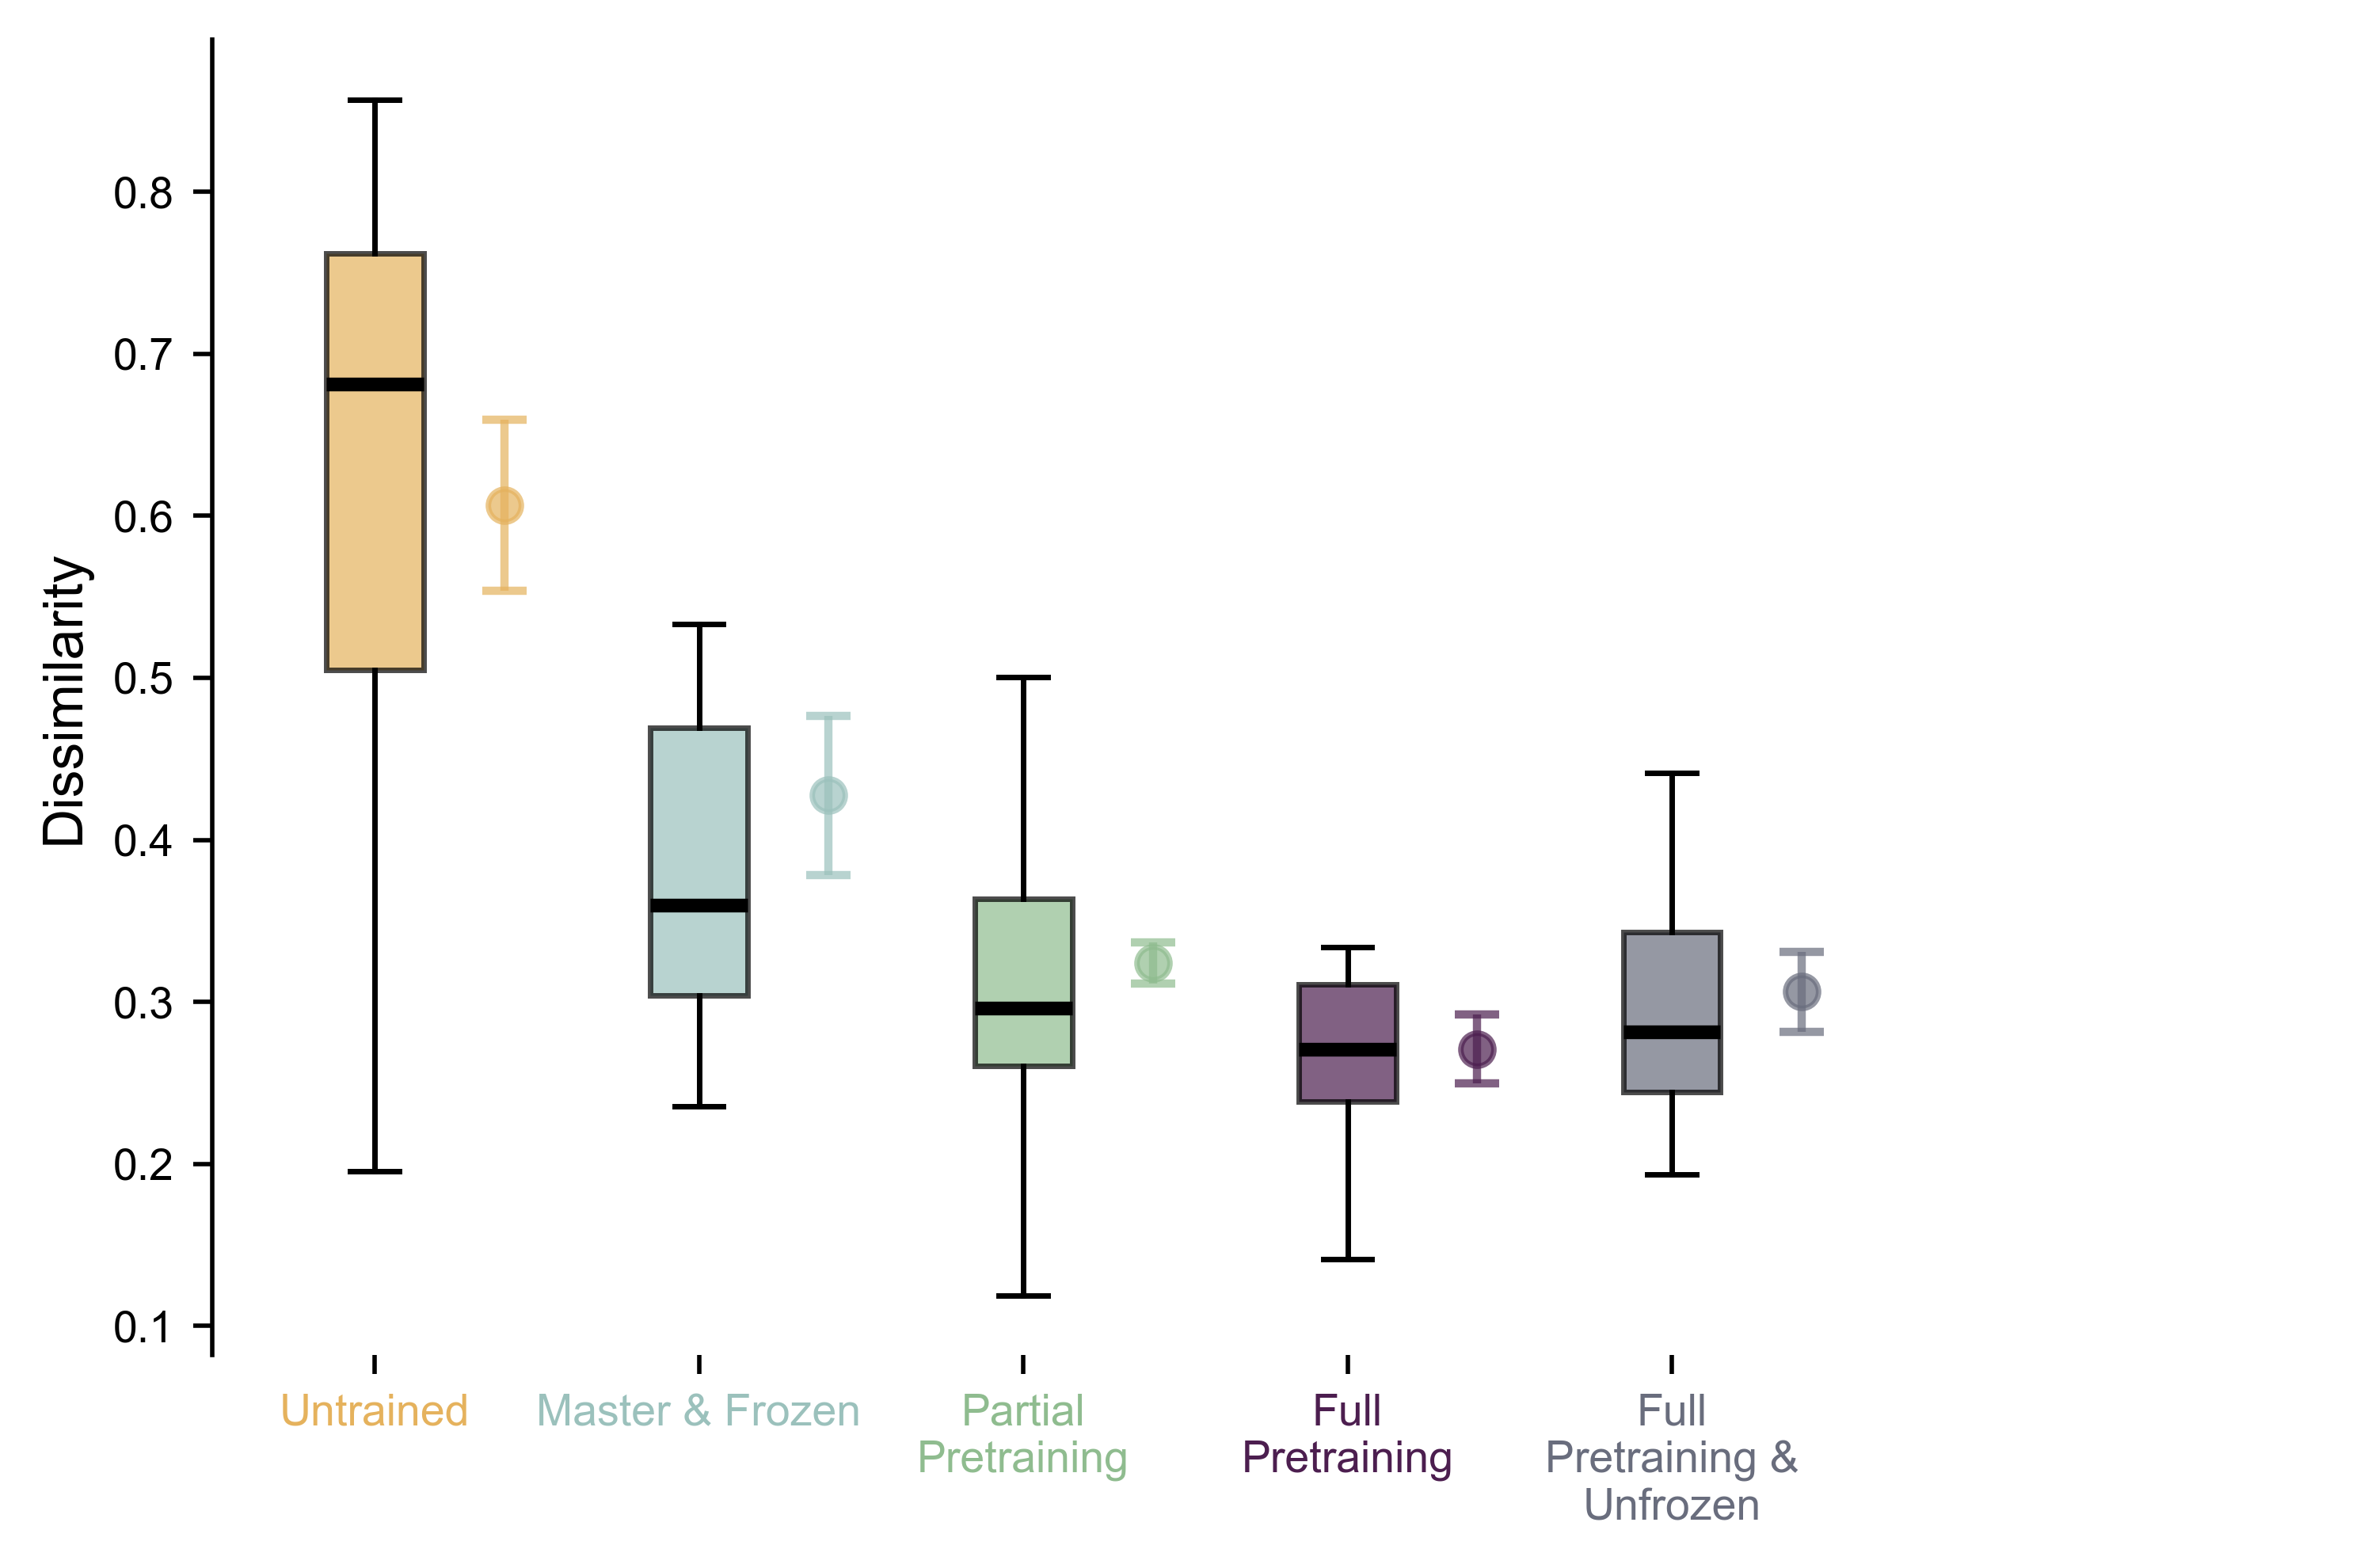

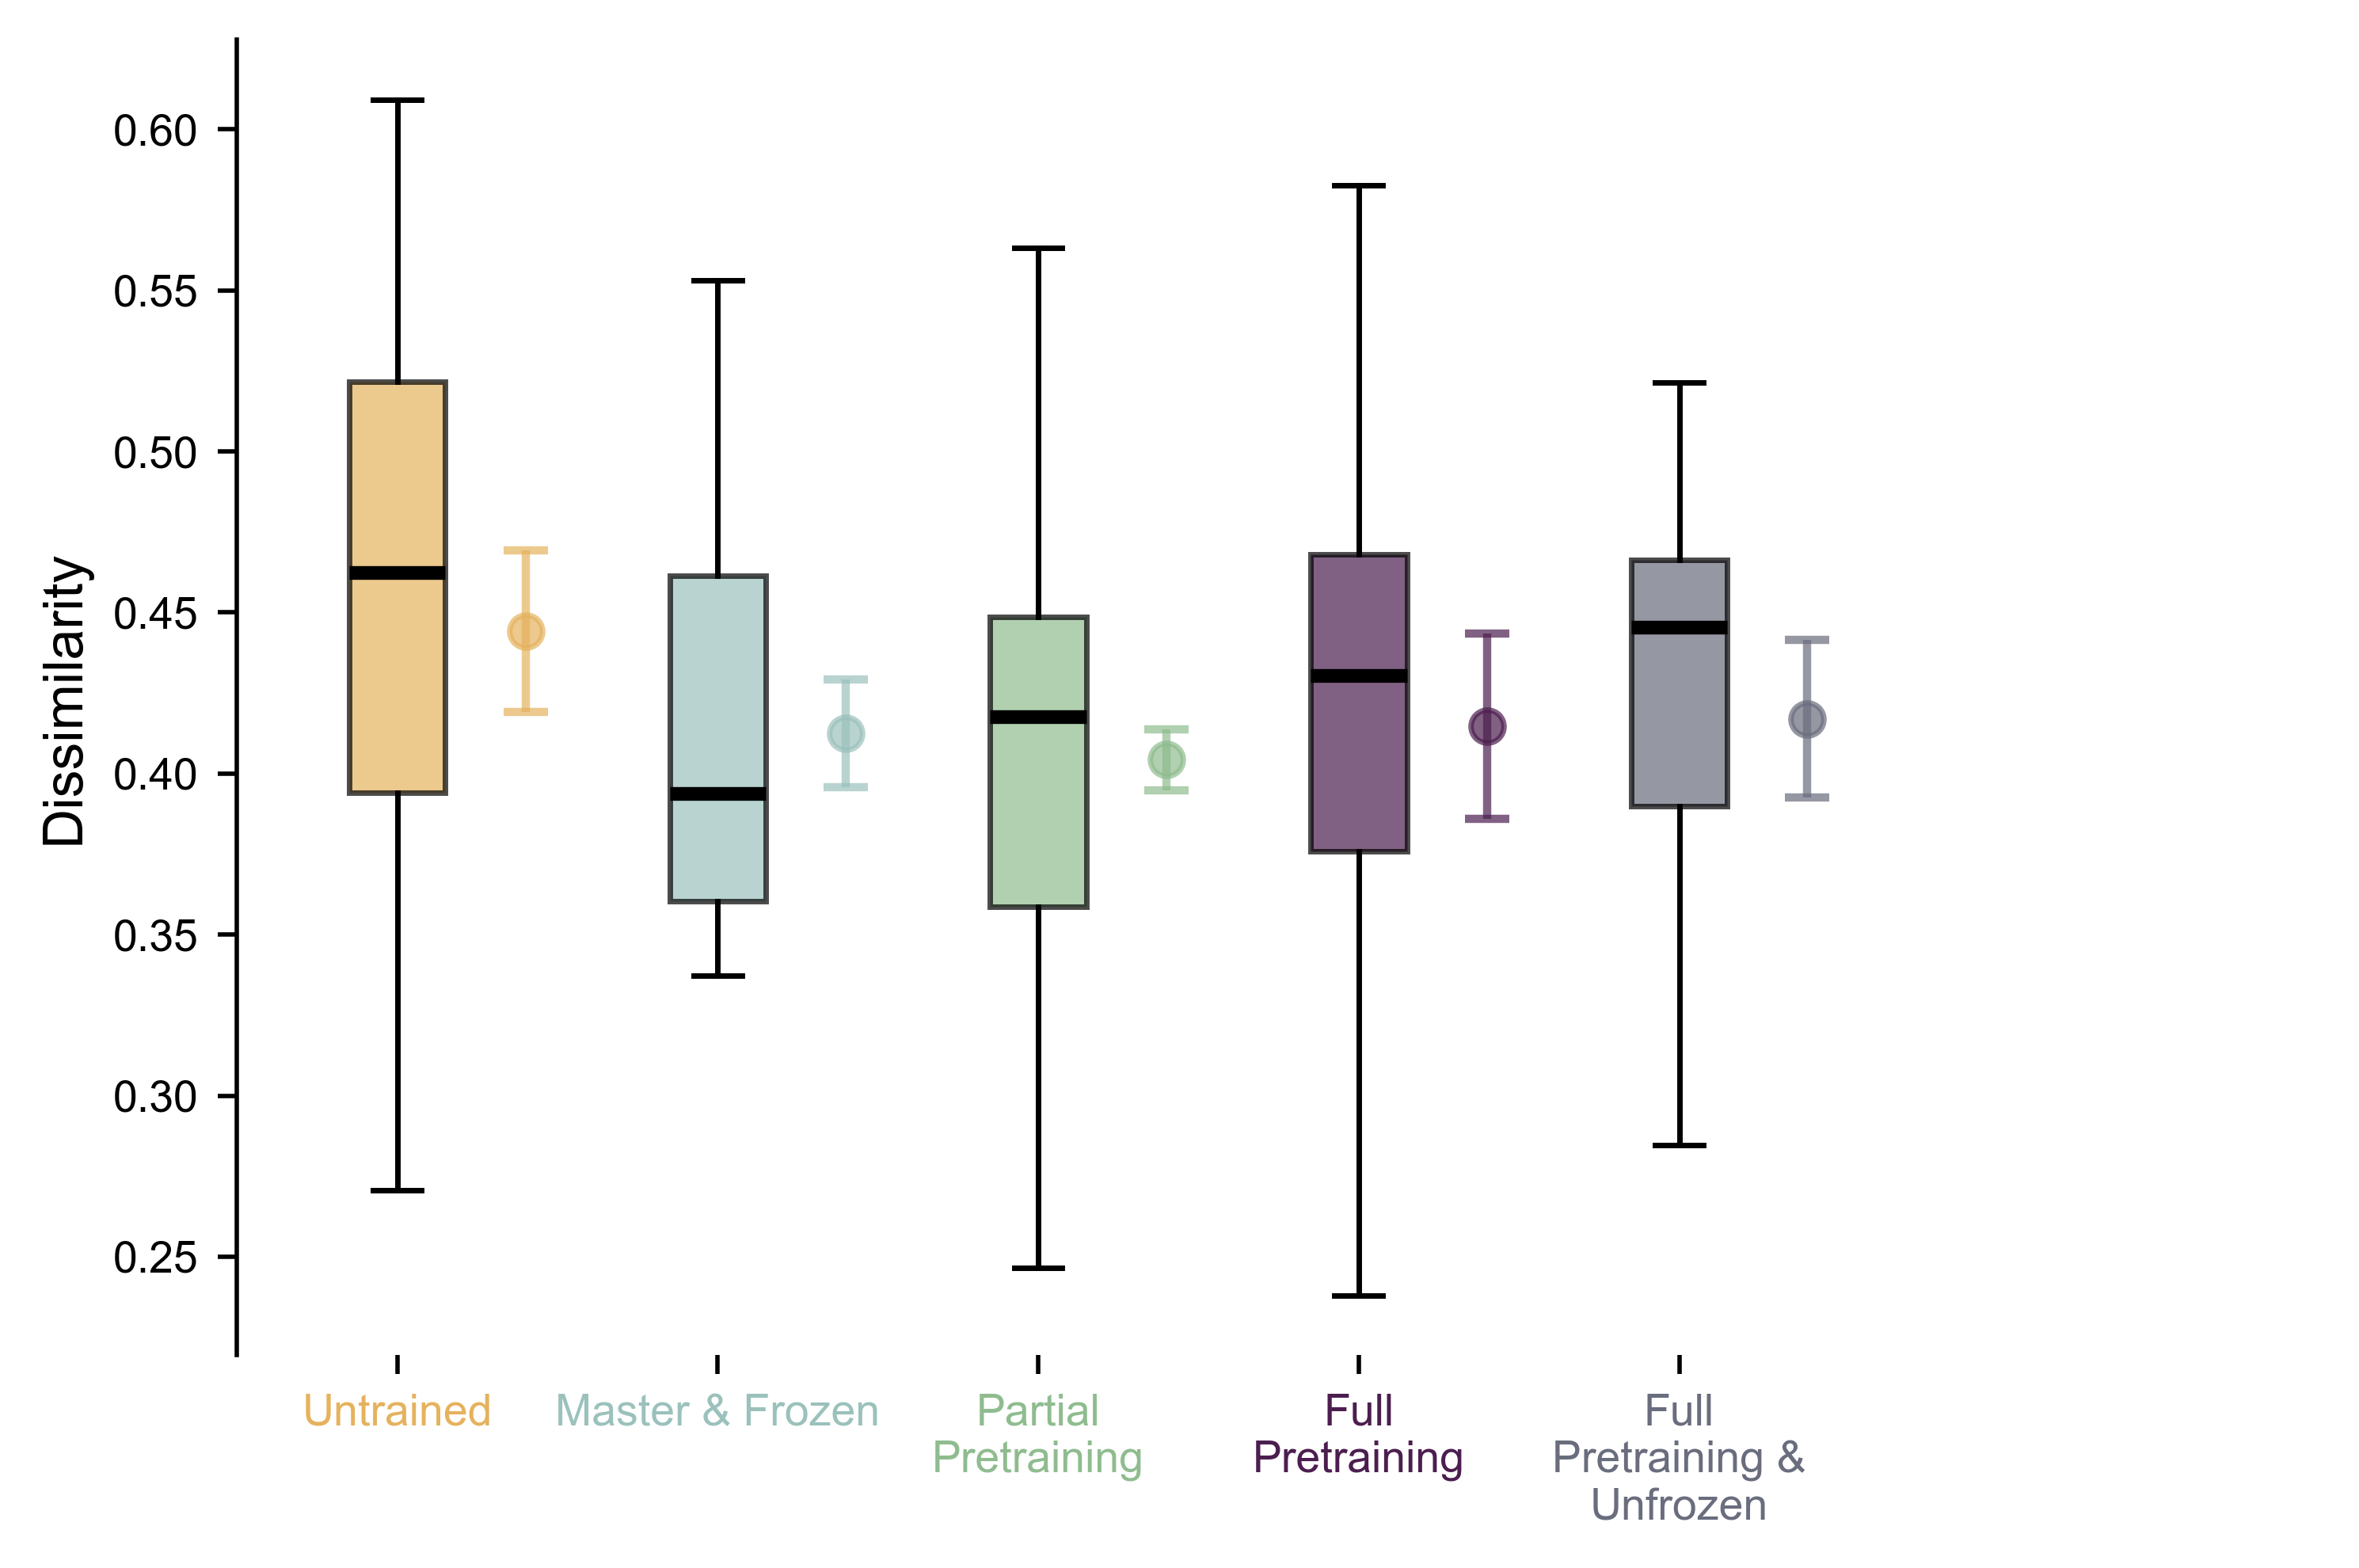

In [18]:
discriminate_df_with_error_bars(df_grouped, groups_base)

In [19]:
# Group by 'group1', 'group2', and 'measure', then calculate median dissimilarities
median_dissimilarities = (
    df_selected.groupby(["group1", "group2", "measure"])["dissimilarity"].mean().reset_index()
)

# Pivot the data to prepare it for the heatmap
pivot_table = median_dissimilarities.pivot_table(
    index="group1", columns="group2", values="dissimilarity"
)

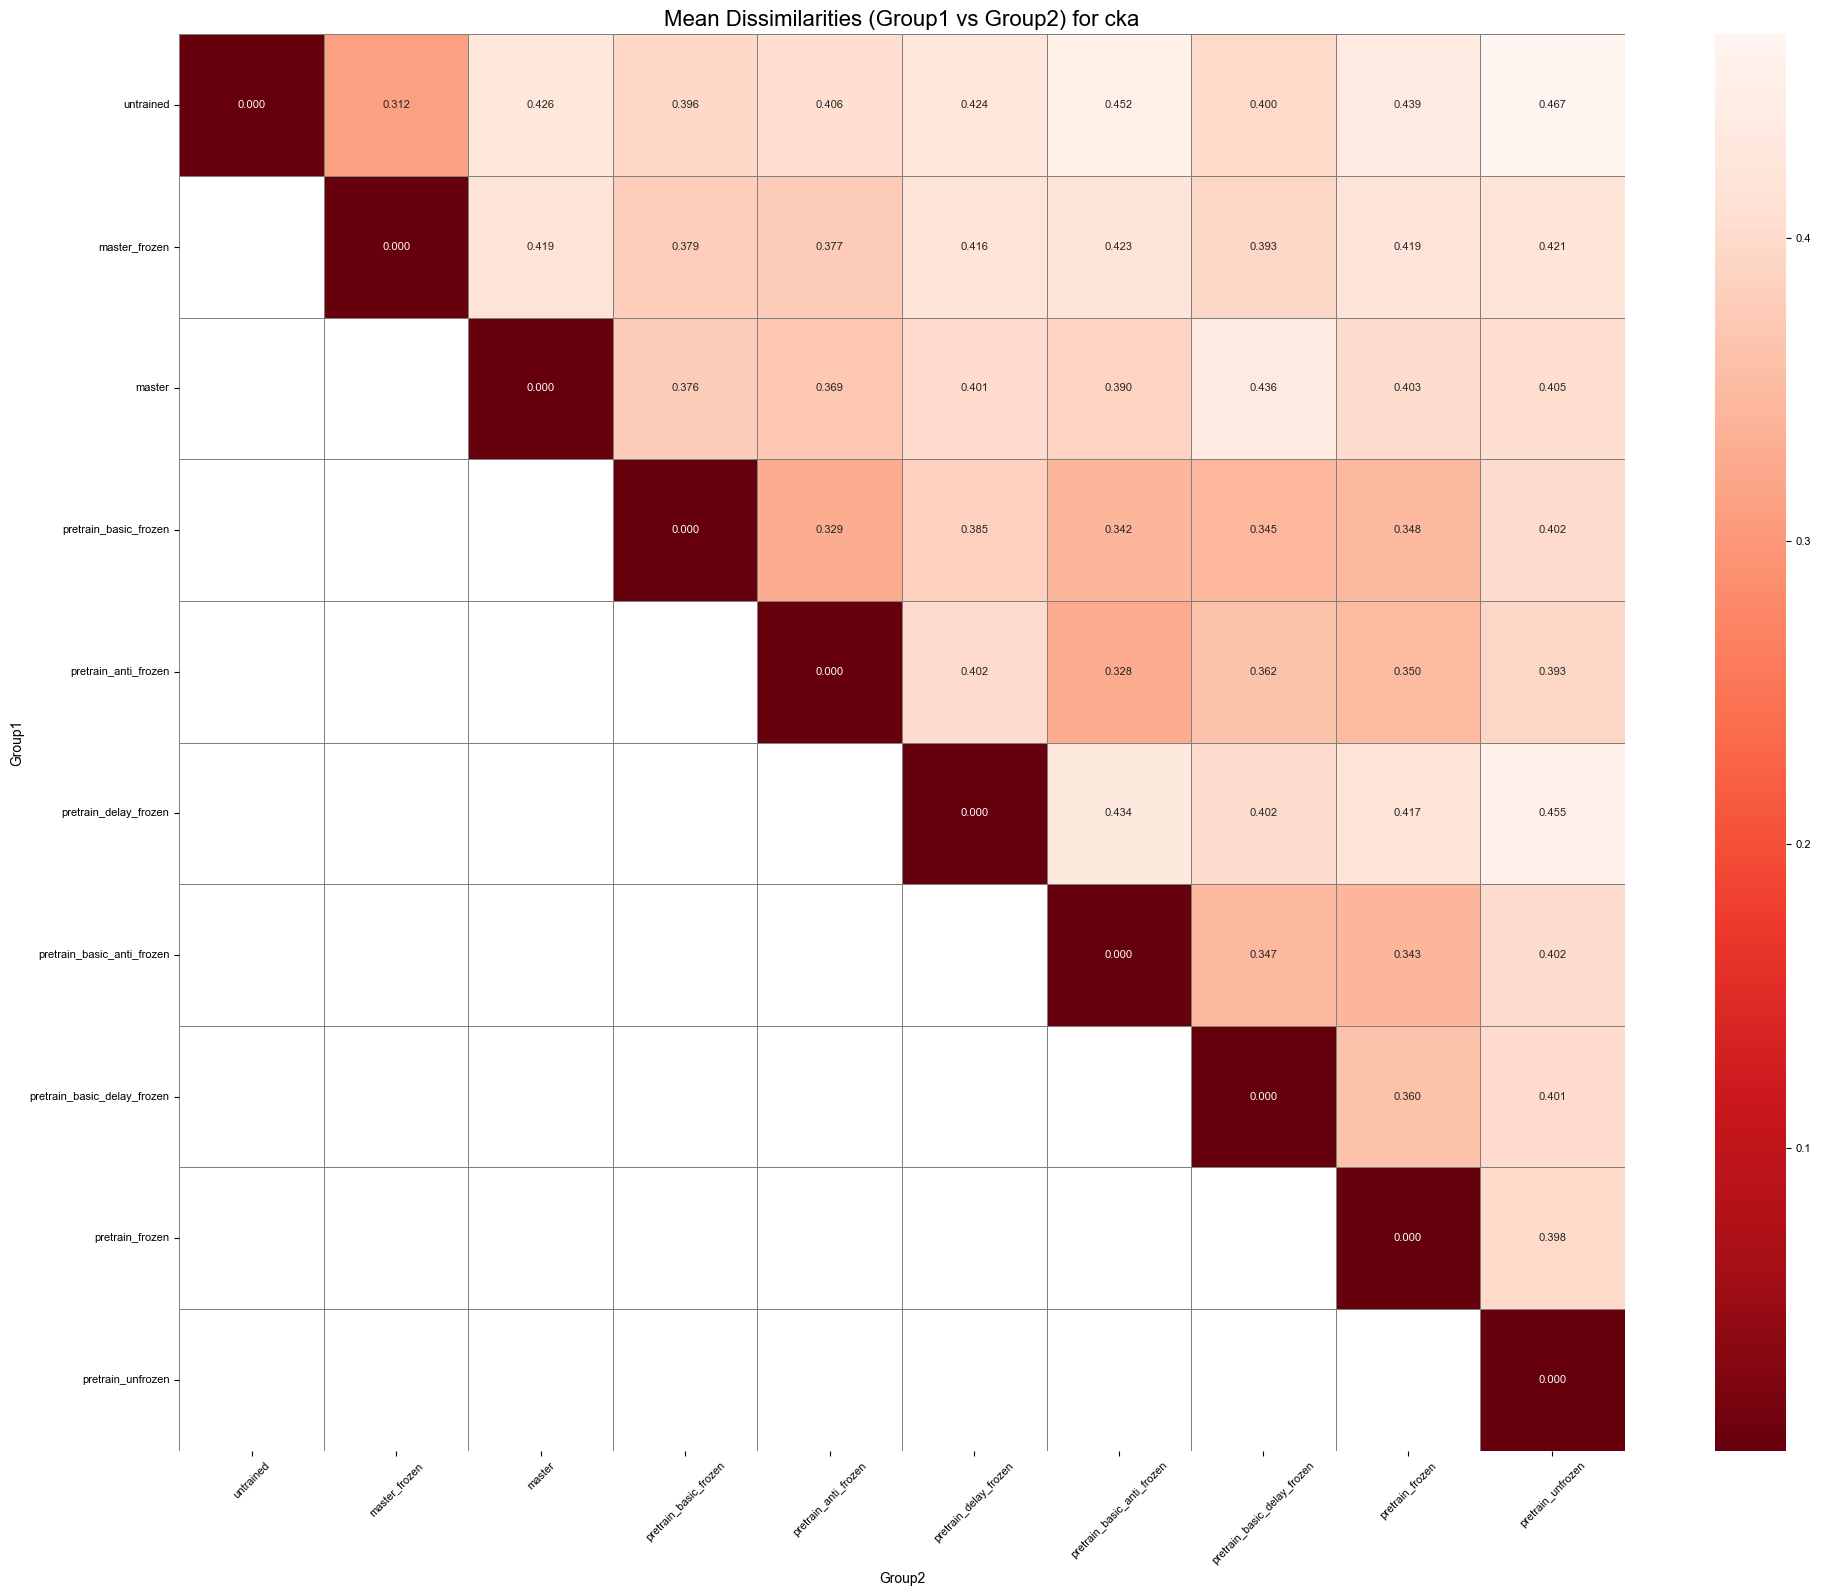

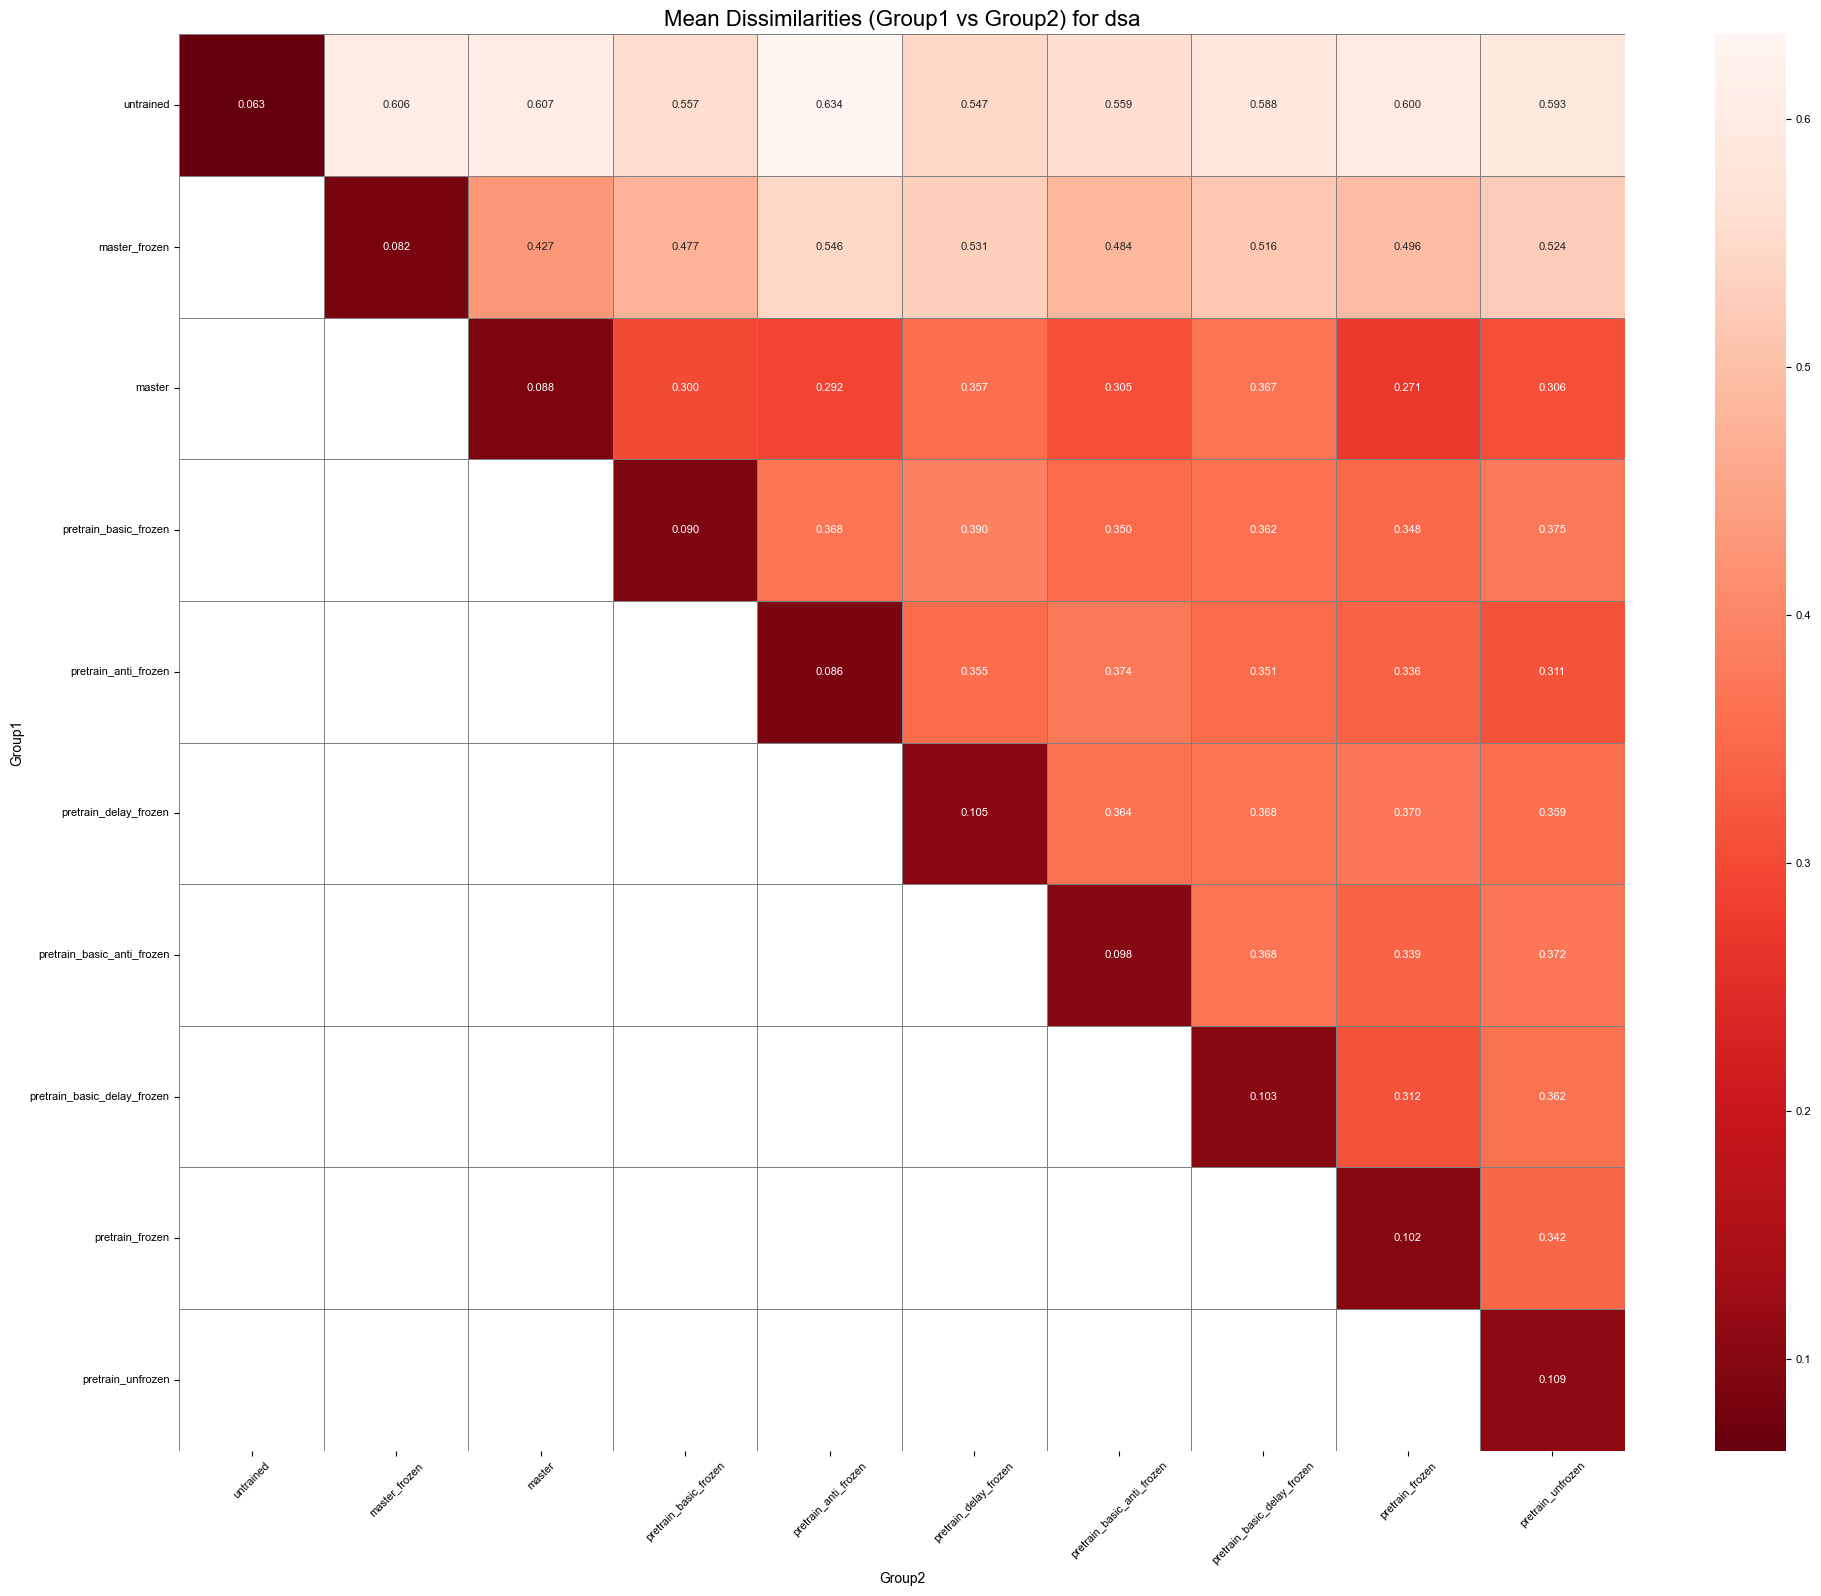

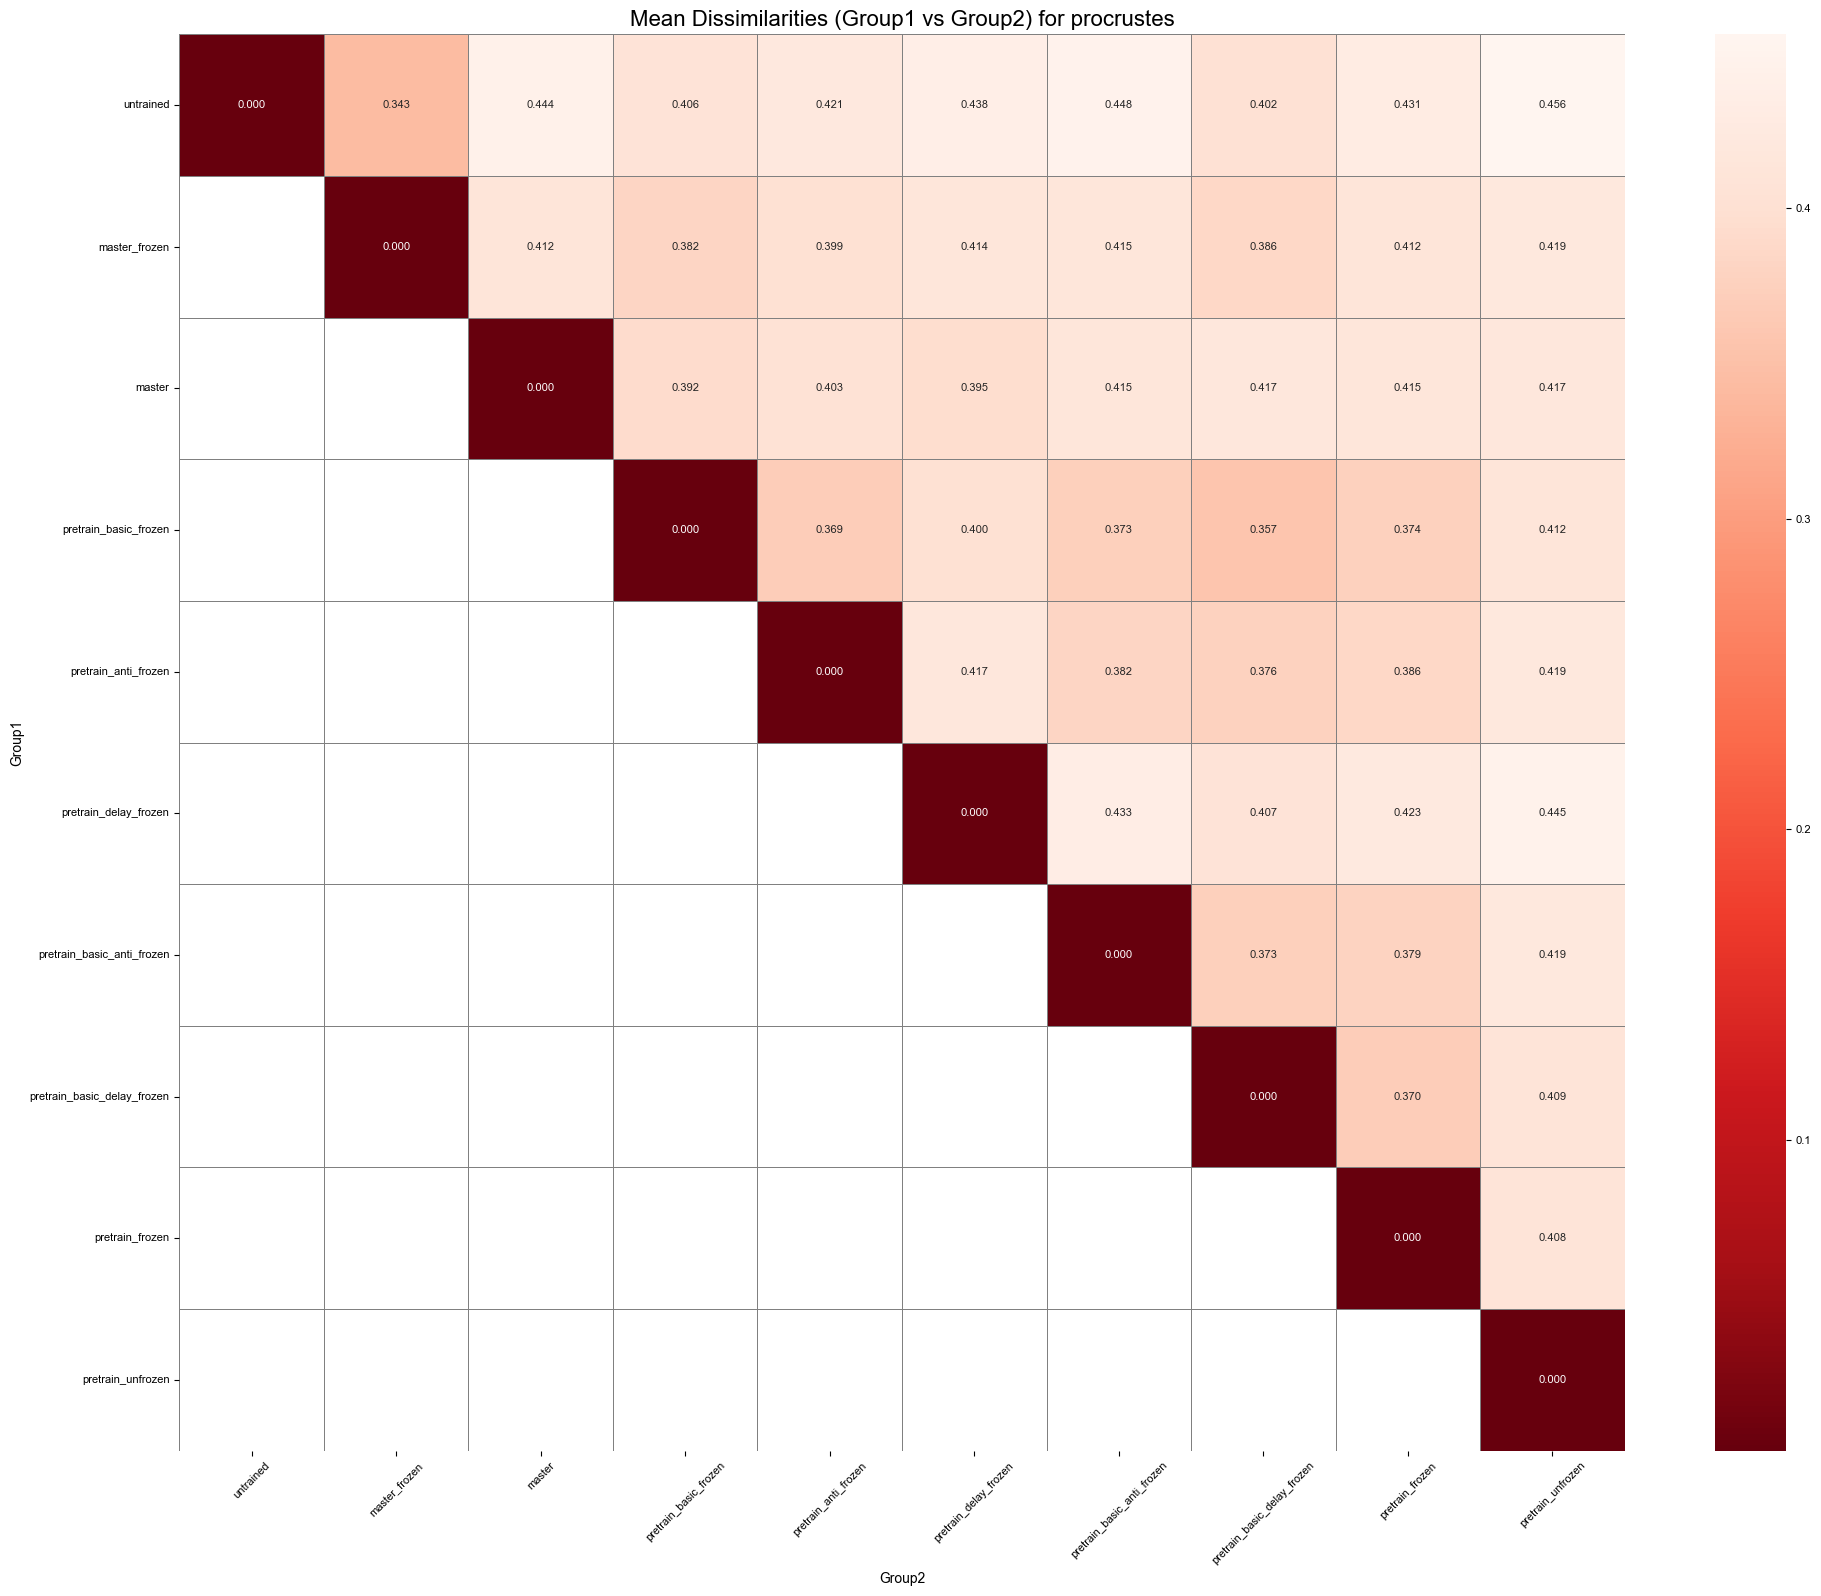

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming median_dissimilarities DataFrame is defined

# Define the desired order for groups
groups = [
    "untrained",
    "master_frozen",
    "master",
    "pretrain_basic_frozen",
    "pretrain_anti_frozen",
    "pretrain_delay_frozen",
    "pretrain_basic_anti_frozen",
    "pretrain_basic_delay_frozen",
    "pretrain_frozen",
    "pretrain_unfrozen",
]

# Unique measures
measures = df_selected["measure"].unique()

# Plot heatmap for each measure
for measure in measures:
    # Filter the pivot table for the specific measure
    measure_pivot = median_dissimilarities[
        median_dissimilarities["measure"] == measure
    ].pivot(index="group1", columns="group2", values="dissimilarity")

    # Reorder the rows and columns according to the specified groups
    measure_pivot = measure_pivot.reindex(index=groups, columns=groups)

    # Create a mask for the lower triangle (excluding the diagonal)
    mask = np.tril(np.ones_like(measure_pivot, dtype=bool), -1)

    # Create a heatmap
    #TODO : same scale for all metrics : Same min max for all metrics
    plt.figure(figsize=(20, 16))
    sns.heatmap(
        measure_pivot,
        annot=True,
        fmt=".3f",
        cmap="Reds_r",
        cbar=True,
        linewidths=0.5,
        linecolor="gray",
        mask=mask,  # Apply the mask to show only the upper triangle including the diagonal
    )
    plt.title(f"Mean Dissimilarities (Group1 vs Group2) for {measure}", fontsize=16)
    plt.xlabel("Group2")
    plt.ylabel("Group1")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

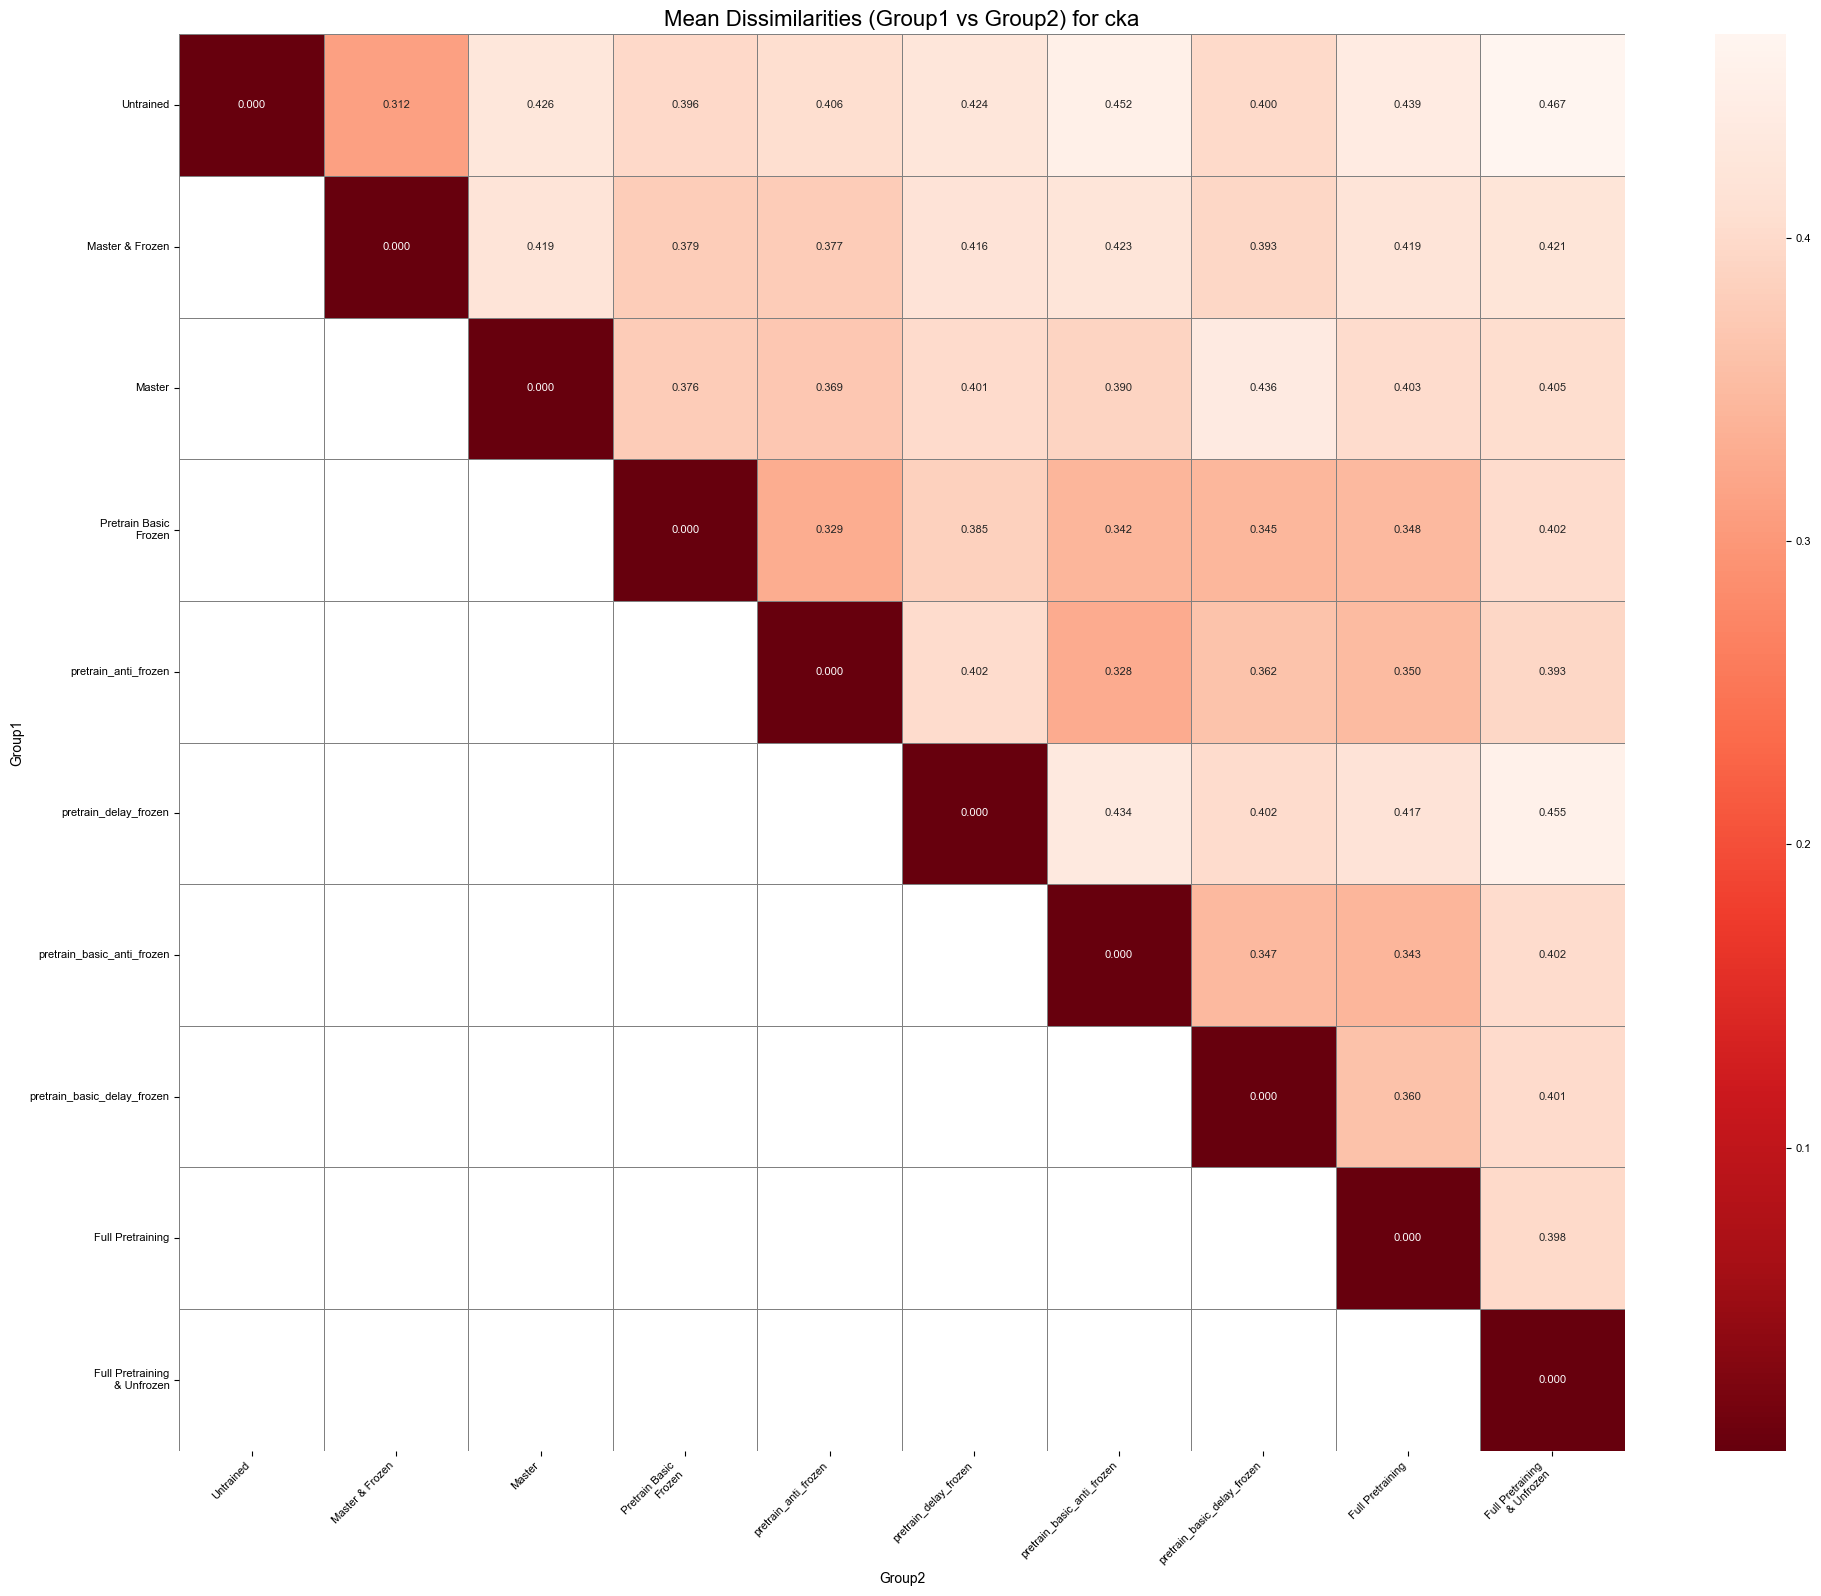

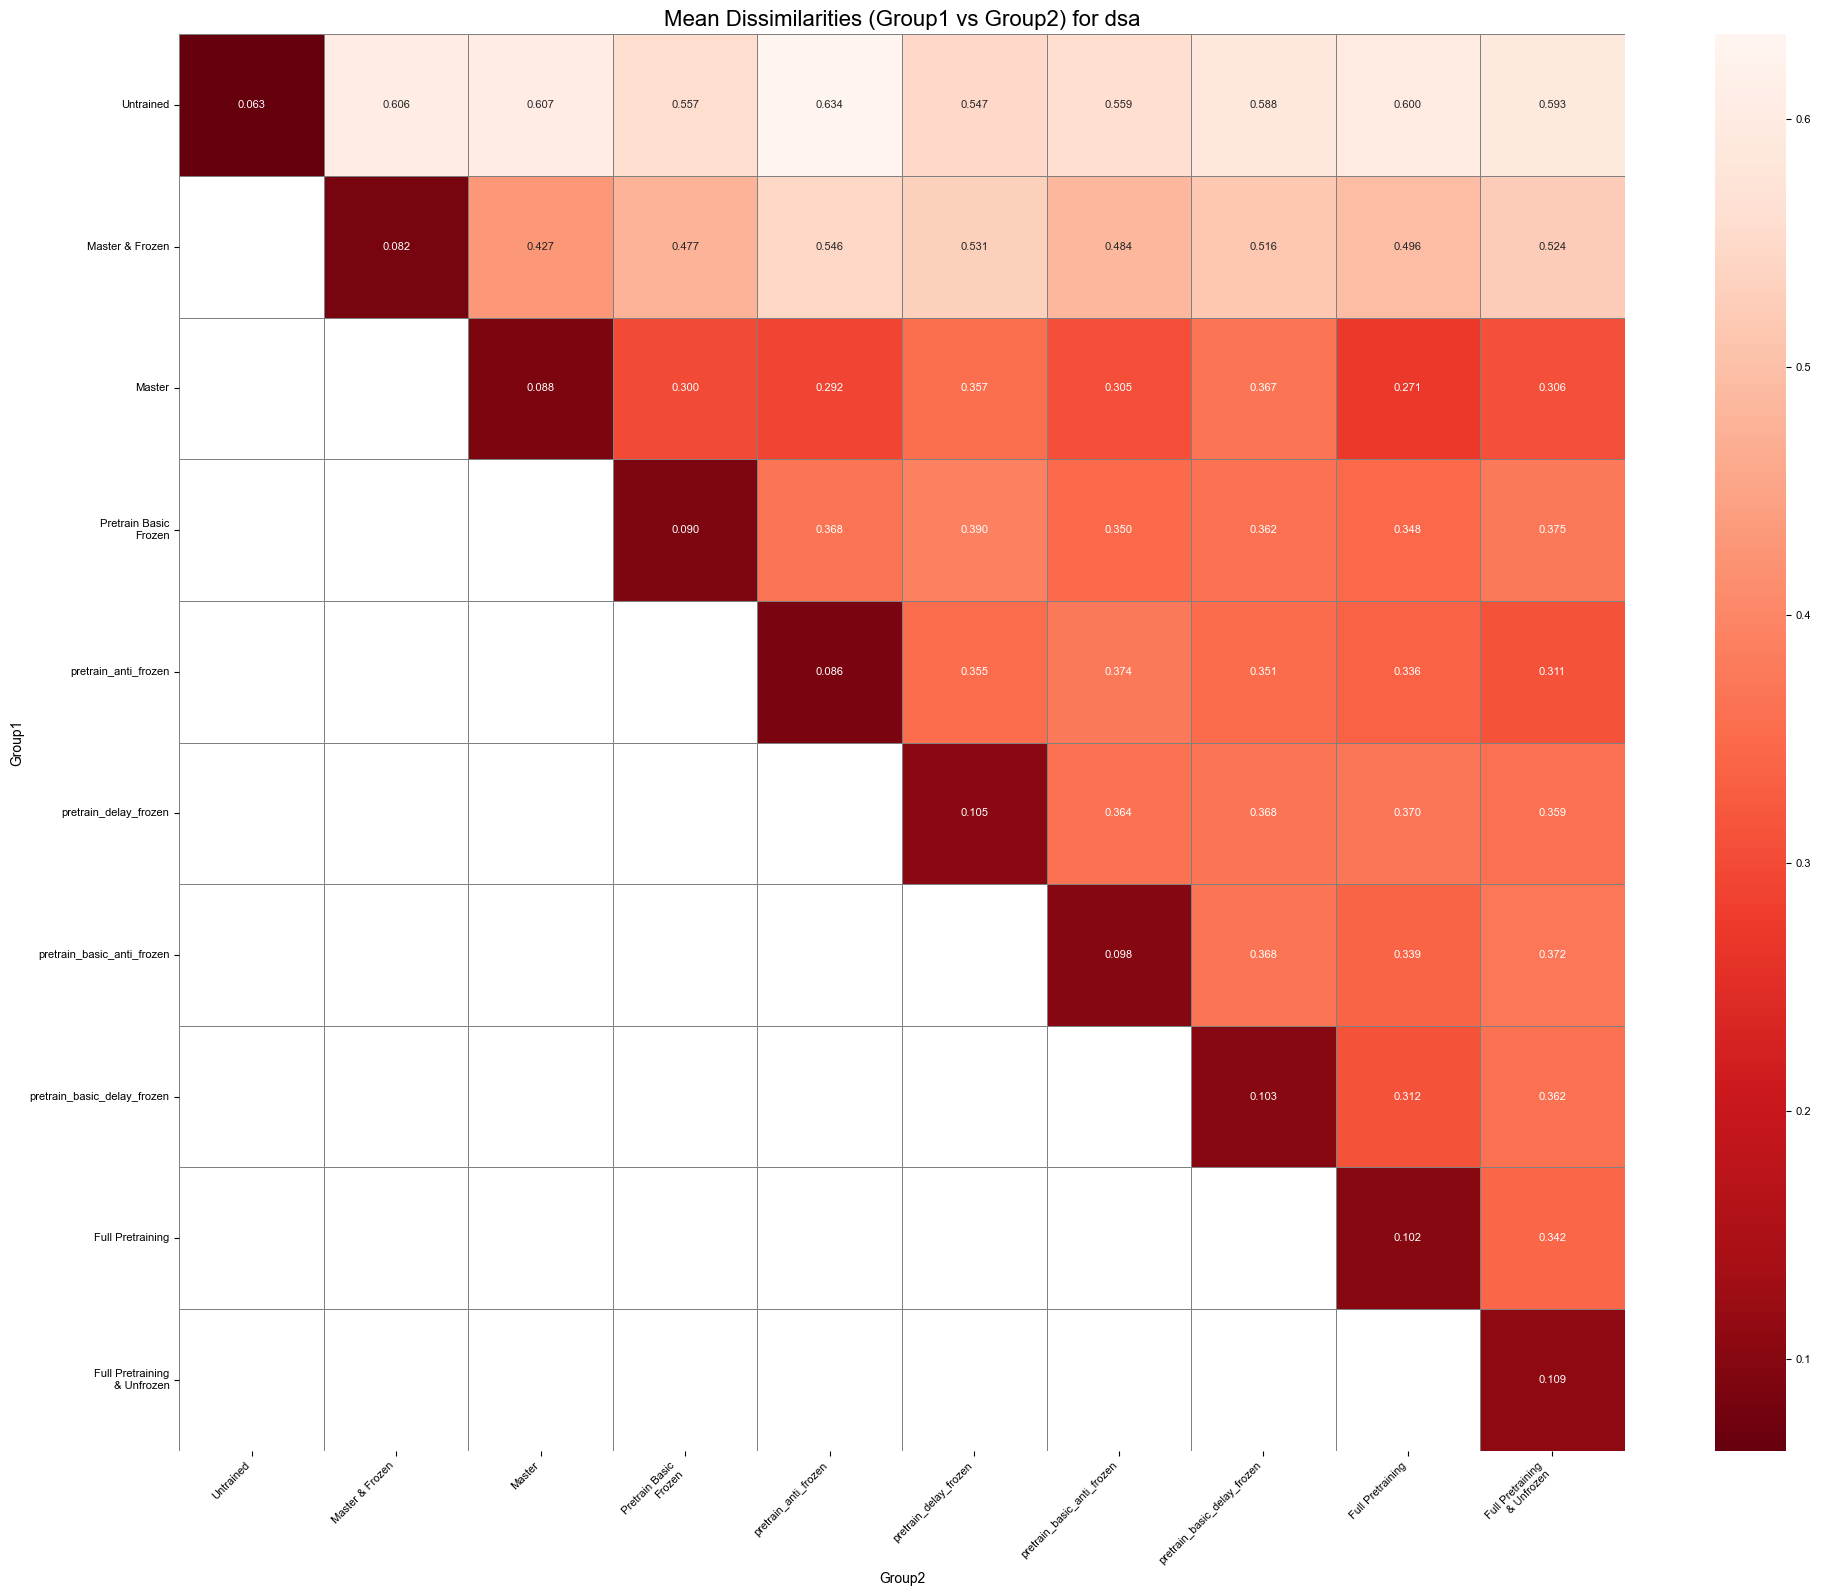

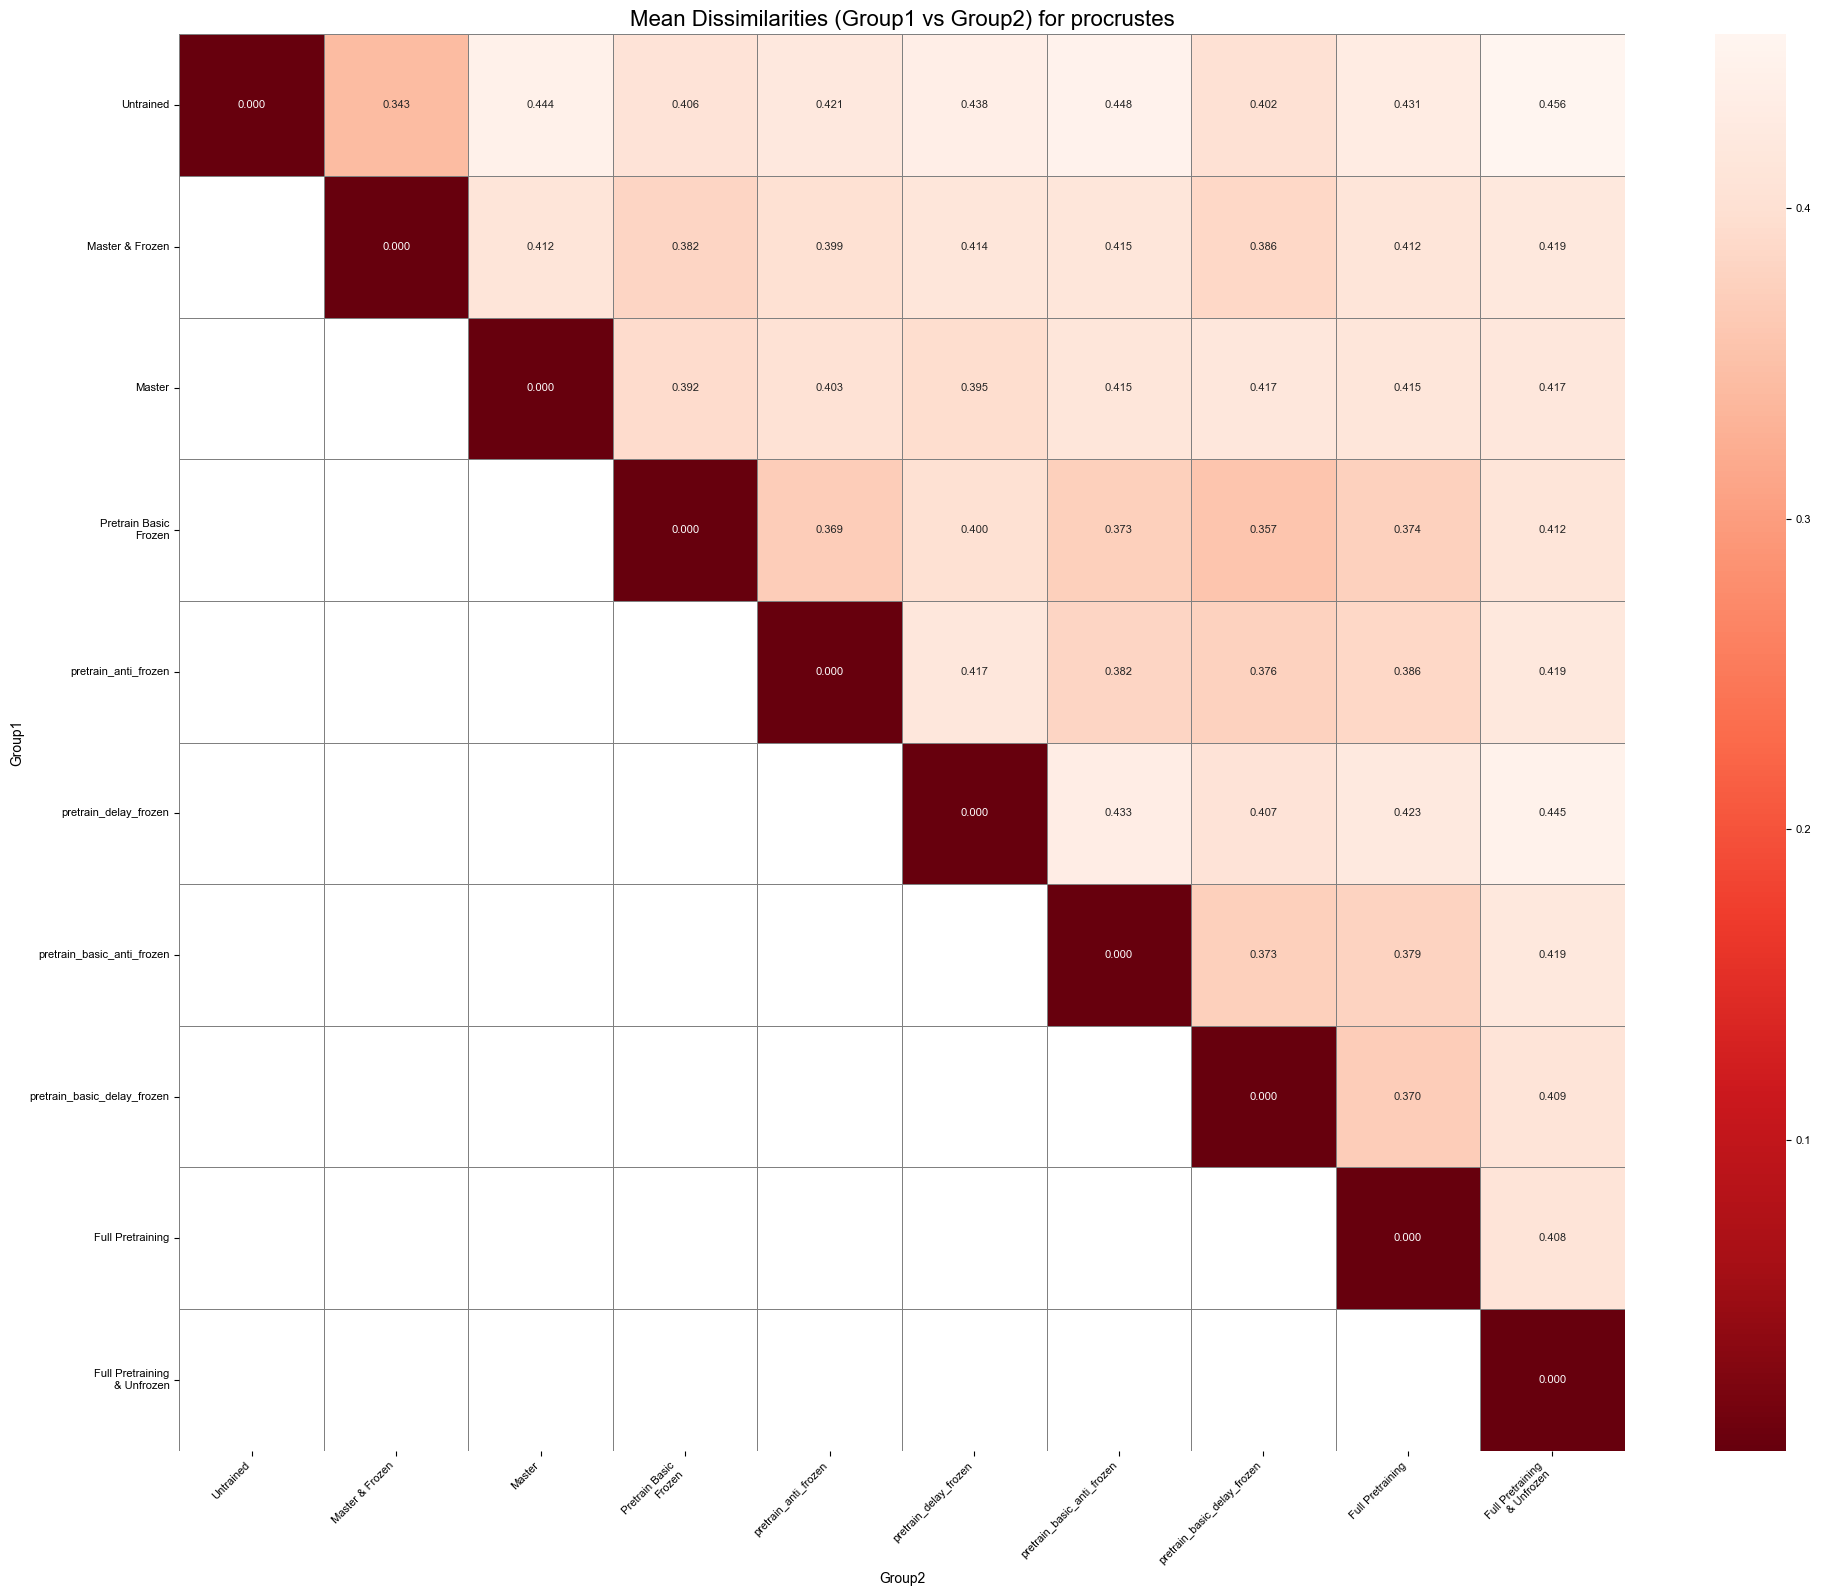

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Update group names to use the new mapping, ensuring two-line names where needed
groups_mapped = [group_mapping_names.get(group, group) for group in groups]

# Unique measures
measures = df_selected["measure"].unique()

# Plot heatmap for each measure
for measure in measures:
    # Filter the pivot table for the specific measure
    measure_pivot = median_dissimilarities[
        median_dissimilarities["measure"] == measure
    ].pivot(index="group1", columns="group2", values="dissimilarity")

    # Reorder the rows and columns according to the specified groups
    measure_pivot = measure_pivot.reindex(index=groups, columns=groups)

    # Rename the indices and columns with the mapped names
    measure_pivot.index = [
        group_mapping_names.get(name, name) for name in measure_pivot.index
    ]
    measure_pivot.columns = [
        group_mapping_names.get(name, name) for name in measure_pivot.columns
    ]

    # Create a mask for the lower triangle (excluding the diagonal)
    mask = np.tril(np.ones_like(measure_pivot, dtype=bool), -1)

    # Create a heatmap
    plt.figure(figsize=(20, 16))
    sns.heatmap(
        measure_pivot,
        annot=True,
        fmt=".3f",
        cmap="Reds_r",
        cbar=True,
        linewidths=0.5,
        linecolor="gray",
        mask=mask,  # Apply the mask to show only the upper triangle including the diagonal
    )
    plt.title(f"Mean Dissimilarities (Group1 vs Group2) for {measure}", fontsize=16)
    plt.xlabel("Group2")
    plt.ylabel("Group1")
    plt.xticks(rotation=45, ha="right")  # Adjust horizontal axis to avoid overlap
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

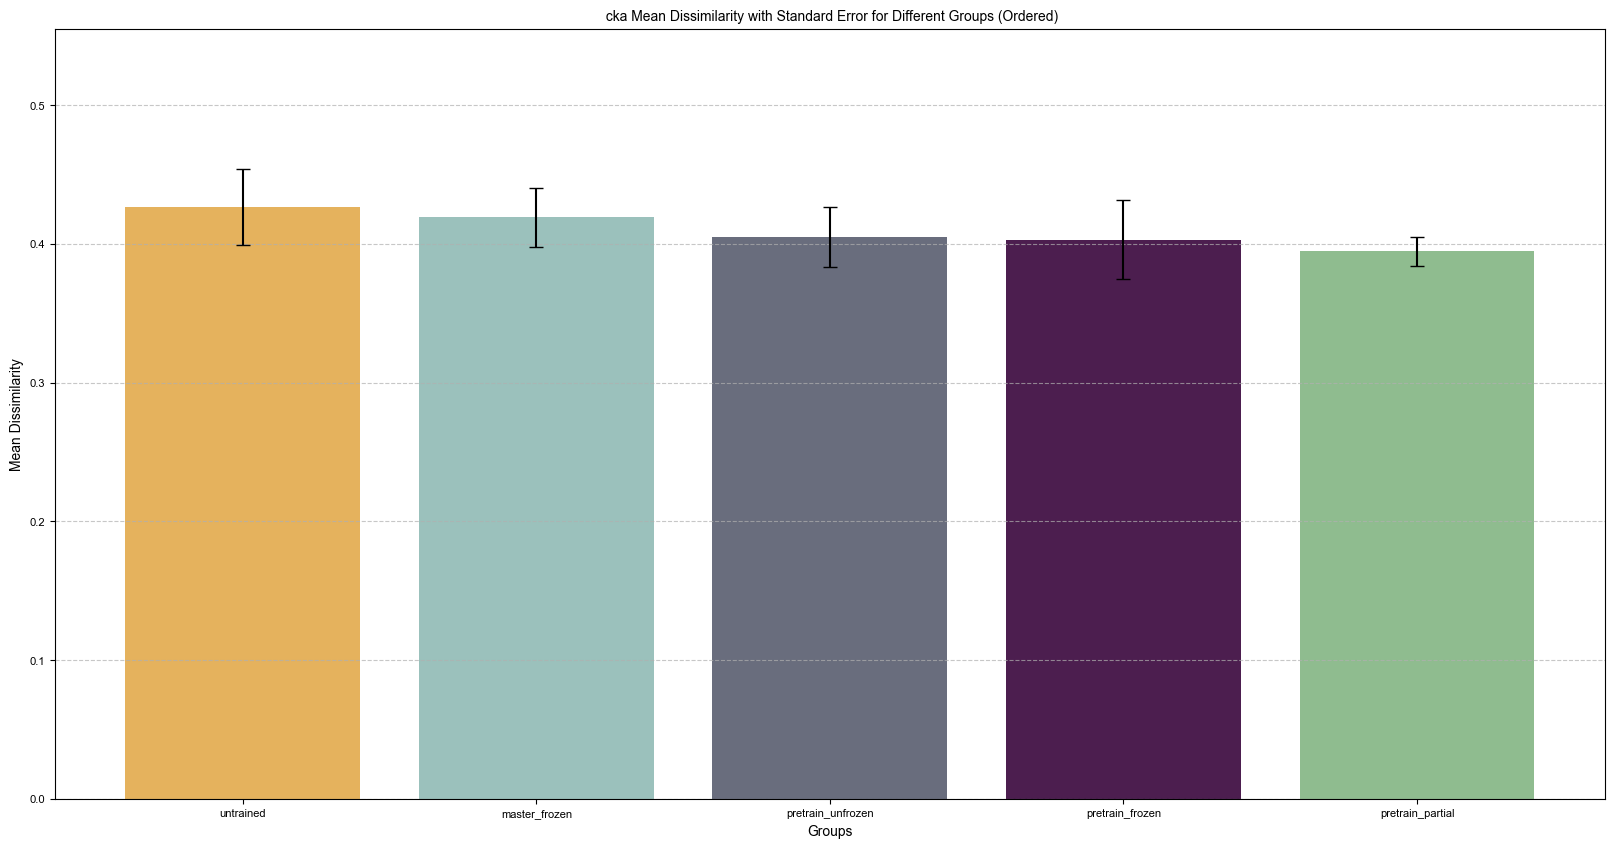

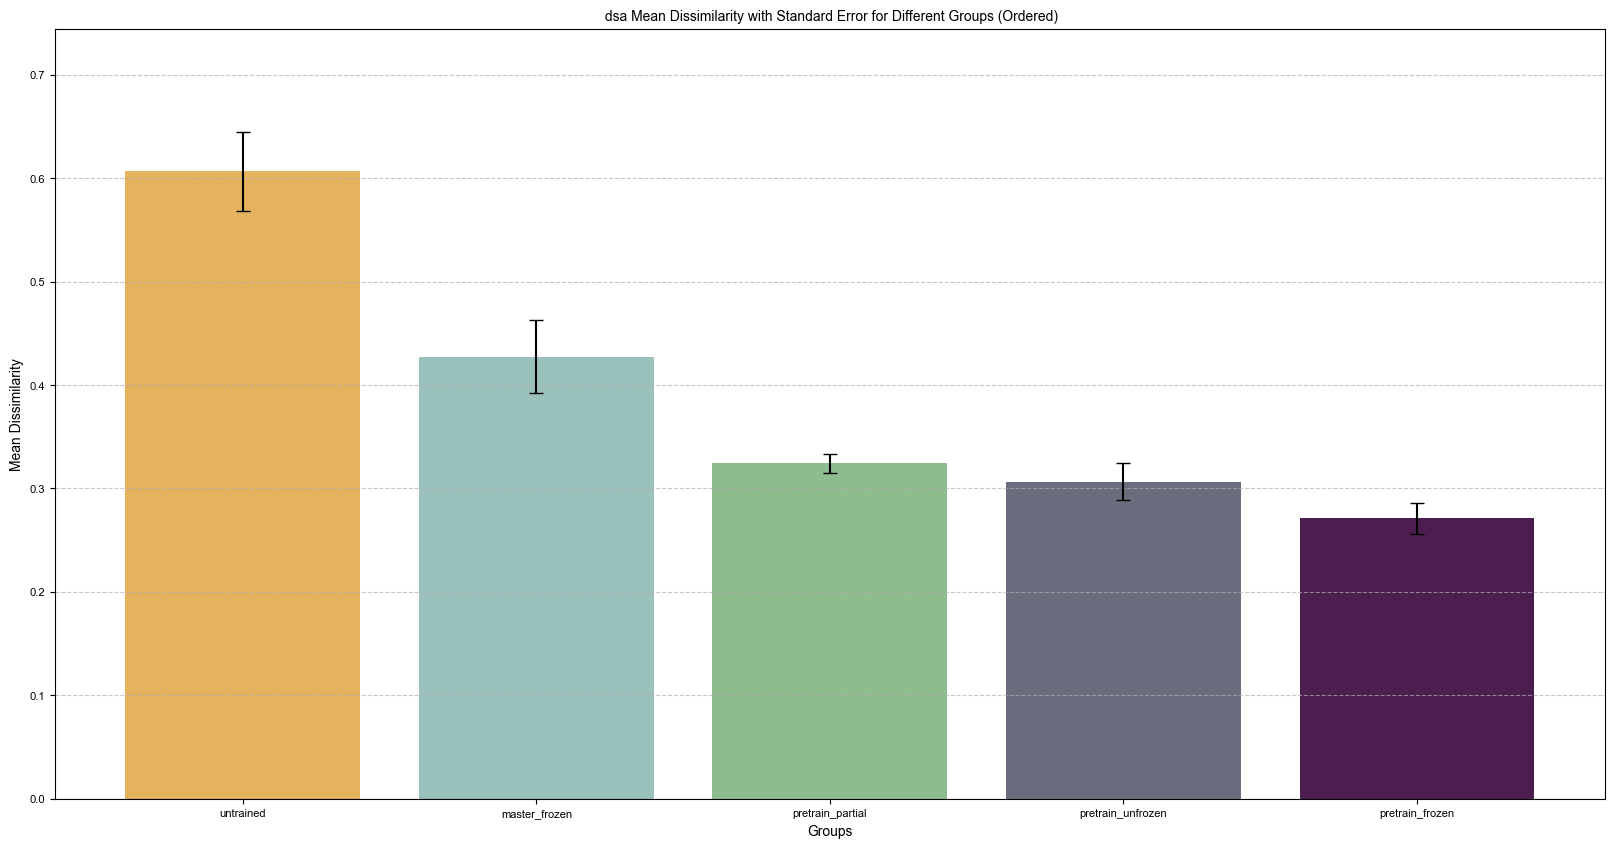

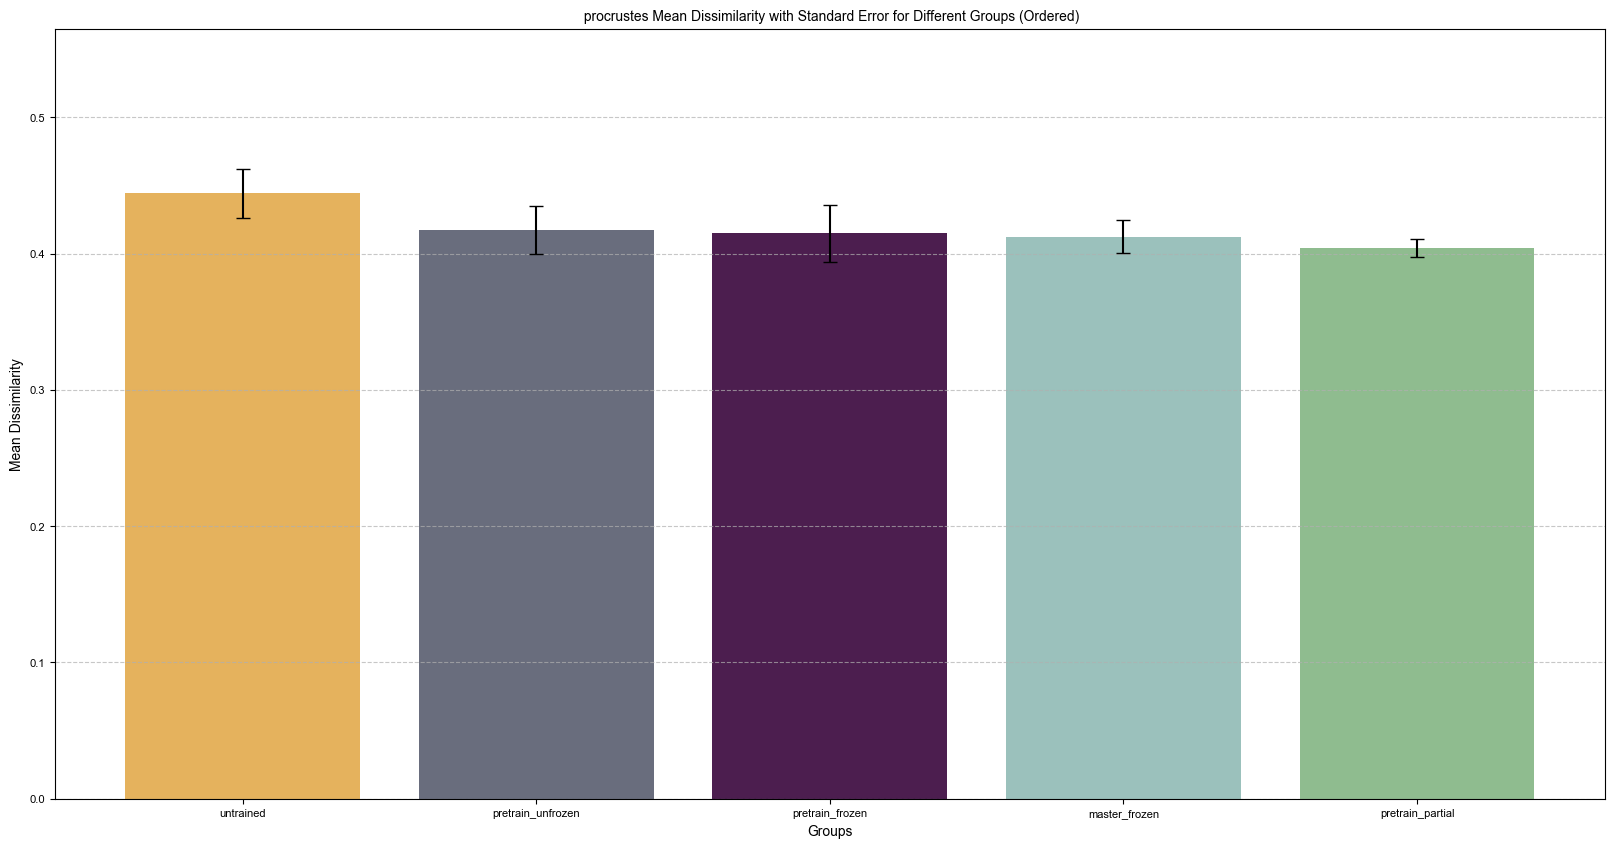

In [22]:
from numpy import mean


for measure in measures:
    # Create a bar chart with error bars
    df_standard = t_standart_error_dissimilarity_all_groups(df_selected, measure)
    groups, mean_dissimilarities, standard_errors = (
        df_standard["group"],
        df_standard["mean_dissimilarities"],
        df_standard["standard_errors"],
    )
    # Step 1: Zip the data together and sort by mean_dissimilarities in descending order
    sorted_data = sorted(zip(mean_dissimilarities, standard_errors, groups), reverse=True)

    # Step 2: Unzip the sorted data back into separate lists
    mean_dissimilarities, standard_errors, groups = zip(*sorted_data)

    # Step 3: Create the bar chart
    plt.figure(figsize=(20, 10))
    colors = [color_mapping.get(group, "gray") for group in groups]
    plt.bar(groups, mean_dissimilarities, yerr=standard_errors, capsize=5, color=colors)
    plt.xlabel("Groups")
    plt.ylabel("Mean Dissimilarity")
    plt.title(f" {measure} Mean Dissimilarity with Standard Error for Different Groups (Ordered)")
    plt.ylim(
        0, max(mean_dissimilarities) + max(standard_errors) + 0.1
    )  # Adjust the y-axis limit if needed
    plt.grid(True, axis="y", linestyle="--", alpha=0.7)

    # Display the plot
    plt.show()

In [26]:
df_test = t_test_all_pairs(df_selected, "dsa")

In [27]:
df_test

,pairs,p_value,adjusted_p_value
0,"(untrained, master_frozen)",1.102140e-03,1.836899e-03
1,"(untrained, pretrain_partial)",7.327906e-21,7.327906e-20
2,"(untrained, pretrain_frozen)",5.093440e-11,2.546720e-10
3,"(untrained, pretrain_unfrozen)",2.393027e-09,7.976758e-09
4,"(master_frozen, untrained)",1.102140e-03,1.836899e-03
5,"(master_frozen, pretrain_partial)",7.621253e-05,1.905313e-04
6,"(master_frozen, pretrain_frozen)",1.590742e-04,3.181483e-04
7,"(master_frozen, pretrain_unfrozen)",3.434389e-03,4.906270e-03
8,"(pretrain_partial, untrained)",7.327906e-21,7.327906e-20
9,"(pretrain_partial, master_frozen)",7.621253e-05,1.905313e-04


/var/folders/rg/xgkyjs4945d6ckms1nn6v0jm0000gn/T/ipykernel_1111/2525771827.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


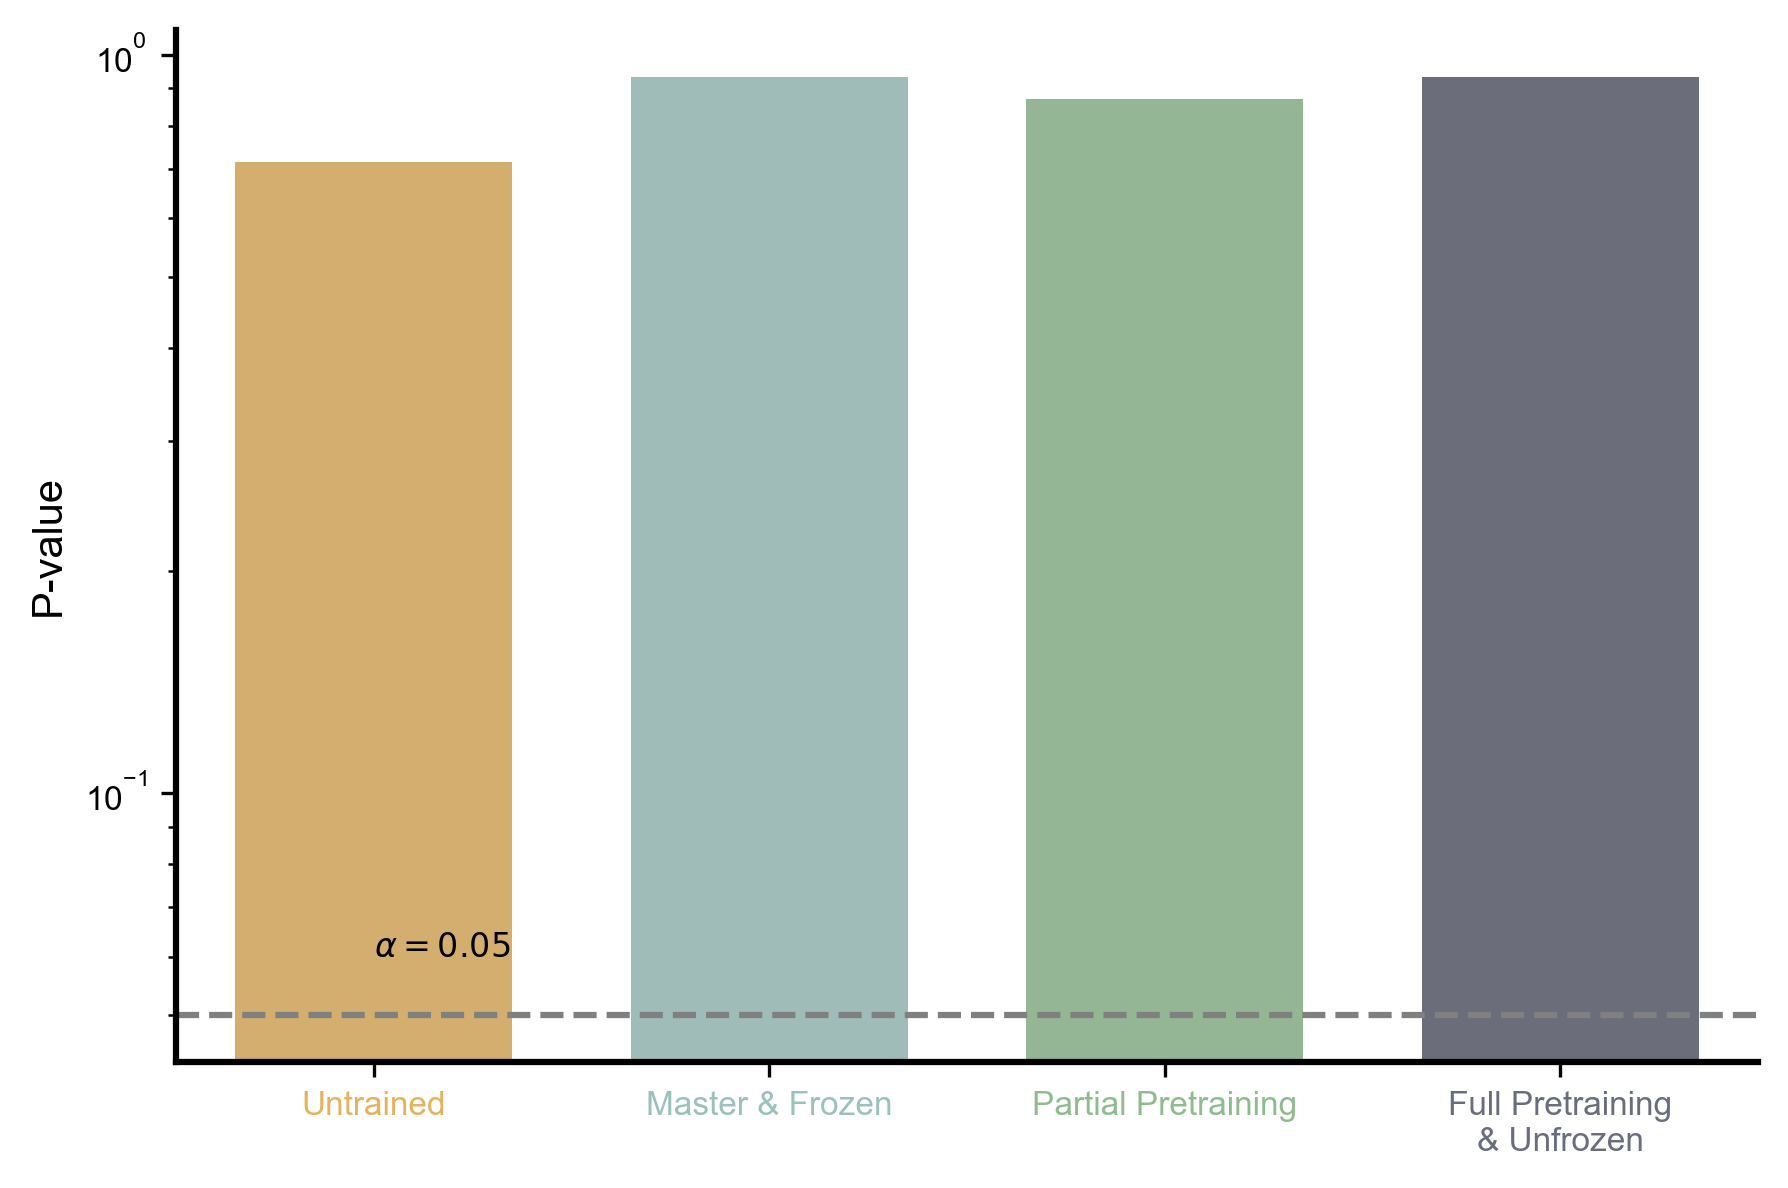

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_test, group_mapping_names, and color_mapping are defined as in the provided example

# Extract relevant comparisons where pretrain_frozen is involved
pretrain_frozen_comparisons = df_test[
    df_test["pairs"].apply(lambda x: "pretrain_frozen" in x)
]

# Create a dataframe for the bar plots
bar_data = pretrain_frozen_comparisons.copy()
bar_data["comparison"] = bar_data["pairs"].apply(
    lambda x: x[0] if x[1] == "pretrain_frozen" else x[1]
)

# Create a palette using your color mapping and rename groups using group_mapping_names
palette = {
    group_mapping_names[group]: color_mapping.get(group, "gray")
    for group in bar_data["comparison"].unique()
}

# Apply group name mapping to the comparison column
bar_data["comparison"] = bar_data["comparison"].map(group_mapping_names)

# Set up the plot with higher DPI for better quality
plt.figure(figsize=(6, 4), dpi=300)  # Increased DPI for better resolution

# Create the bar plot with reduced bar width
ax = sns.barplot(
    x="comparison",
    y="adjusted_p_value",
    data=bar_data,
    palette=palette,
    width=0.7,  # Reduce the width of the bars slightly to allow them to be closer
    dodge=False,  # Ensure no separation between bars for grouped data
)

# Set log scale for p-values
plt.yscale("log")

# Horizontal line at p-value threshold (0.05)
plt.axhline(y=0.05, color="grey", linestyle="--")

# Add text for \alpha = 0.05 using LaTeX formatting
plt.text(x=0, y=0.06, s=r"$\alpha = 0.05$", color="black")

# Set axis labels
plt.xlabel("")
plt.ylabel("P-value")

# Rotate x-axis labels and align with colors
plt.xticks(rotation=0)
for tick_label, color in zip(
    ax.get_xticklabels(), [palette[label.get_text()] for label in ax.get_xticklabels()]
):
    tick_label.set_color(color)

# Customize the plot appearance to remove all spines except the left and bottom
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(1.5)
ax.spines["bottom"].set_linewidth(1.5)

# Adjust the font size of the y-axis label for better readability

# Remove title and legend
plt.title("")
plt.legend().remove()

# Display the plot
plt.tight_layout()
plt.show()